In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as Data
from tqdm import tqdm

import numpy as np
import copy
import json

USE_CUDA = True

In [2]:
def readfile(data):
    with open(data, "r", encoding="utf-8") as f:
        content = f.read().splitlines()
        
    return content

def schema_load(schema_root):
    raw_dict = "".join(readfile(schema_root))
    dict2json = "".join(raw_dict.split()[2:])

    json_acceptable_string = dict2json.replace("'", "\"")
    schema = json.loads(json_acceptable_string)
    
    return schema

def define_entity(schema):
    tag_type = list(schema['tagging'])
    
    entity_tag = []
    for k in list(schema['entity'].keys()):
        entity_tag.append(schema['entity'][k]['tag'])
        
    TAG = []
    for t in tag_type:
        for e in entity_tag:
            if t!='O':
                TAG.append(t+'-'+e)  
                
    TAG = [UNKOWN_TAG, PAD_TAG] + TAG + ['O']   

    return TAG

def tag2ix(TAG):
    tag_to_ix={t:i for i,t in enumerate(TAG)}
    return tag_to_ix

def define_relation(schema):
    relation_type = list(schema['relation'])
    
    relation_tag = []
    for k in list(schema['relation'].keys()):
        relation_tag.append(schema['relation'][k]['tag'])
    
    relation_tag = [REL_PAD] + [REL_NONE] + relation_tag
        
    return relation_tag

# ==================================================

def get_word_and_label(_content, start_w, end_w):
    word_list = []
    ent_list = []
    rel_list = []
    
    for word_set in _content[start_w:end_w]:
        word_set = word_set.split()
        if len(word_set)==1:
            word_list.append(' ')
            ent_list.append('O')
            rel_list.append(REL_NONE)
        
        else:
            word_list.append(word_set[0])
            ent_list.append(word_set[1])

            try:
                testerror = word_set[2]
            except IndexError:
                rel_list.append(REL_NONE)
            else:
                rel_list.append(word_set[2:])
    
    return word_list, ent_list, rel_list

def split_to_list(content):
    init = 0
    word_list = []
    ent_list = []
    rel_list = []

    for now_token, c in enumerate(content):
        if c=='':
            words, ents, rels = get_word_and_label(content, init, now_token)
            init = now_token+1
            word_list.append(words)
            ent_list.append(ents)
            rel_list.append(rels)
            
    return word_list, ent_list, rel_list

# ==================================================

def word2index(word_list):
    word_to_ix = {"<UNKNOWN>":0, "<PAD>":1}
    for sentence in word_list:
        for word in sentence:
            if word not in word_to_ix:
                word_to_ix[word] = len(word_to_ix)
                
    return word_to_ix

def dict_inverse(tag_to_ix):
    ix_to_tag = {v: k for k, v in tag_to_ix.items()}
    return ix_to_tag

def index2tag(indexs, ix_to):
    to_tags = [ix_to[i] for i in indexs.cpu().numpy()]
    return to_tags

# ==================================================

def find_max_len(word_list):
    max_len = 0
    for i in range(len(word_list)):
        if max_len<len(word_list[i]):
            max_len=len(word_list[i])
            
    return max_len

# ====== filter the length of sentence more than MAX_LEN =======

def filter_len(word_list):
    reserved_index = []
    for i in range(len(word_list)):
        if len(word_list[i])<MAX_LEN:
            reserved_index.append(i)
            
    return reserved_index


def filter_sentence(reserved_index, word_list, ent_list, rel_list):
    filter_word = list(word_list[i] for i in reserved_index)
    filter_ent = list(ent_list[i] for i in reserved_index)
    filter_rel = list(rel_list[i] for i in reserved_index)
    return filter_word, filter_ent, filter_rel

# ==================================================

def pad_seq(seq, isrel):
    if isrel:
        seq += [REL_NONE for i in range(MAX_LEN-len(seq))]
    else:
        seq += [PAD_TAG for i in range(MAX_LEN-len(seq))]
    return seq

def pad_all(filter_word, filter_ent, filter_rel):
    input_padded = [pad_seq(s, False) for s in filter_word]
    ent_padded = [pad_seq(s, False) for s in filter_ent]
    rel_padded = [pad_seq(s, True) for s in filter_rel]
    
    return input_padded, ent_padded, rel_padded

def deep_copy_lists(filter_word, filter_ent, filter_rel):
    f_w = copy.deepcopy(filter_word)
    f_e = copy.deepcopy(filter_ent)
    f_r = copy.deepcopy(filter_rel)
    
    return f_w, f_e, f_r

# ==================================================

def prepare_sequence(seq, to_ix):
    idxs = []
    for w in seq:
        if w not in to_ix:
            idxs.append(to_ix[UNKOWN_TAG])
        else:
            idxs.append(to_ix[w])
    
#     idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

def prepare_all(seqs, to_ix):
    seq_list = []
    for i in range(len(seqs)):
        seq_list.append(prepare_sequence(seqs[i], to_ix))
        
    seq_list = torch.stack(seq_list)
        
    return seq_list



def prepare_rel(rel_padded, to_ix):
    
    rel_ptr = torch.zeros(len(rel_padded), MAX_LEN, MAX_LEN, dtype=torch.long) 
    
    # 對當前的token，去比較之前所有出現過的entity，是否有關係，建成矩陣
    # [B*ML*ML]，第二維ML是當前token，第三維ML是根據當前token對之前出現過的entity紀錄關係，以index紀錄
    for i, rel_seq in enumerate(rel_padded):
        rel_dict = {}
        for j, token_seq in enumerate(rel_seq):
            rel_ptr[i][j][:j+1] = 1
            if token_seq != REL_NONE:
                for k, rel in enumerate(token_seq):

                    # if 是第一次出現，紀錄後面數字(標第幾對)和關係位置(A OR B)
                    # 假如下次出現又是同個關係位置(A)，依然紀錄
                    # 直到下次出現關係位置B，依照之前紀錄的A位置的字，然後在第三維去標關係

                    rel_token = rel.split('-')
                    if rel_token[1] not in rel_dict:
                        rel_dict[rel_token[1]] = {'rel':rel_token[0], 'loc':rel_token[2], 'idx':[j]}

                    elif rel_token[1] in rel_dict and rel_dict[rel_token[1]]['loc']==rel_token[2]:
                        rel_dict[rel_token[1]]['idx'].append(j)

                    else:
                        record_loc = rel_dict[rel_token[1]]['idx']
                        for idxx in record_loc:
                            rel_ptr[i][j][idxx] = to_ix[rel_token[0]]
                            
    return rel_ptr
                


# ==================================================

def dataload(input_var, ent_var, rel_var, raw_input):
    torch_dataset = Data.TensorDataset(input_var, ent_var, rel_var, raw_input)

    loader = Data.DataLoader(
        dataset=torch_dataset,      # torch TensorDataset format
        batch_size=BATCH_SIZE,      # mini batch size
        shuffle=True,               
        num_workers=2,       
#         drop_last=True
    )
    
    return loader

# ==================================================
def softmax_entity(entity):
    entity = entity.view(BATCH_SIZE,ent_size).argmax(1)
    return entity

In [3]:
class Attn(nn.Module):
    def __init__(self, attn_input, attn_output, rel_size):
        super(Attn, self).__init__()
        
        self.attn_input = attn_input
        self.attn_output = attn_output
        self.rel_size = rel_size
        
        self.w1 = nn.Linear(self.attn_input, self.attn_output)
        self.w2 = nn.Linear(self.attn_input, self.attn_output)
        self.tanh = nn.Tanh()
        self.v = nn.Linear(self.attn_output, self.rel_size, bias=False)
        self.softmax = nn.LogSoftmax(dim=2)
        
        
    def forward(self, encoder_outputs):
        
        decoder = encoder_outputs[:,-1,:].unsqueeze(1)                       #B*1*(ts+LE) [128,1,8]
        encoder_score = self.w1(encoder_outputs)                             #B*now len*ATTN_OUT
        decoder_score = self.w2(decoder)                                     #B*1*ATTN_OUT
        energy = self.tanh(encoder_score+decoder_score)                      #B*now len*ATTN_OUT            
        
        energy = self.v(energy)                                              #B*now len*rel_size
        
        
        # 針對每個entity做softmax，去顯示他們的關係權重
        # 主要都會是rel_none
        # 對第二維(rel)做softmax
        p = self.softmax(energy)                                         #B*now len*rel_size
        
        return p
    

In [4]:
class Entity_Typing(nn.Module):
    def __init__(self, vocab_size, ent_tag_to_ix, embedding_dim, hidden_dim1, hidden_dim2, \
                 label_embed_dim, rel_tag_to_ix):
        
        super(Entity_Typing, self).__init__()
        self.embedding_dim = embedding_dim                   #E
        self.hidden_dim1 = hidden_dim1                       #h1
        self.hidden_dim2 = hidden_dim2                       #h2
        self.label_embed_dim = label_embed_dim               #LE
        self.vocab_size = vocab_size                         #vs
        self.ent_to_ix = ent_tag_to_ix
        self.ent_size = len(ent_tag_to_ix)                   #es
        self.rel_to_ix = rel_tag_to_ix
        self.rel_size = len(rel_tag_to_ix)                   #rs           
        
        self.dropout = nn.Dropout(p=0.3)
        self.bn = nn.BatchNorm1d(DENSE_OUT, momentum=0.5, affine=False)
        
        
        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        
#         self.bilstm = nn.LSTM(embedding_dim, hidden_dim1 // 2,
#                             num_layers=2, bidirectional=True, batch_first=True, dropout=0.2)        
        self.bilstm = nn.GRU(embedding_dim, hidden_dim1 // 2,
                            num_layers=2, bidirectional=True, batch_first=True, dropout=0.2)
        
        
        self.dense = nn.Linear(hidden_dim1, DENSE_OUT)
        self.top_hidden = nn.LSTMCell(DENSE_OUT+label_embed_dim, hidden_dim2)          
        

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim2, self.ent_size)
        self.softmax = nn.LogSoftmax(dim=1)
        self.label_embed = nn.Linear(self.ent_size, self.label_embed_dim)
        
        self.attn = Attn(ATTN_IN, ATTN_OUT, self.rel_size)
        
        
    def init_hidden1(self):       
        hidden = torch.randn(2*2, self.batch, self.hidden_dim1 // 2)    #4*B*(h1/2)

        return (hidden.cuda(), hidden.cuda())if USE_CUDA else (hidden,hidden)
    
    def init_hidden2(self):       
        hidden = torch.randn(self.batch, self.hidden_dim2)              #B*h2

        return (hidden.cuda(), hidden.cuda())if USE_CUDA else (hidden,hidden)
    
    def init_label_embed(self):
        hidden = torch.zeros(self.batch, self.label_embed_dim)          #B*LE
        return hidden.cuda()if USE_CUDA else hidden
    
    def create_entity(self):
        output_tensor = torch.zeros(self.batch, MAX_LEN, self.ent_size)  #B*ML*es
        return output_tensor.cuda()if USE_CUDA else output_tensor
    
    def create_rel_matrix(self):
        rel_tensor = torch.zeros(self.batch, MAX_LEN, MAX_LEN, self.rel_size)  #B*ML*ML*rs
        return rel_tensor.cuda()if USE_CUDA else rel_tensor
    
    
        
    def forward(self, sentence):
        
        self.batch = sentence.size(0)
#         self.hidden1 = self.init_hidden1()                      #4*B*(h1/2)
        entity_tensor = self.create_entity()                    #B*ML*es
        rel_tensor = self.create_rel_matrix()                   #B*ML*ML*rs
        
        

        embeds = self.word_embeds(sentence)                     #B*ML*E,[128, 100, 20]
        
#         bilstm_out, self.hidden1 = self.bilstm(embeds, self.hidden1)
        bilstm_out, hidden1 = self.bilstm(embeds)
        # bilstm_out -> B*ML*h1,[128, 100, 10]
        # self.hidden1 -> ( 4*B*(h1/2), 4*B*(h1/2) )
        
        # bn
        bilstm_out = self.bn(bilstm_out)
        dense_out = self.dense(bilstm_out)                      #B*ML*DENSE_OUT,[128, 100, 100]
        
        
        encoder_sequence_l = [] 

        for length in range(MAX_LEN):
            now_token = dense_out[:,length,:]
            now_token = torch.squeeze(now_token, 1)
            if length==0:
                
#                 fake_hidden=(100)
#                 noise_x = random(100)
                self.hidden2 = self.init_hidden2()
                self.zero_label_embed = self.init_label_embed()
                combine_x = torch.cat((now_token, self.zero_label_embed),1)  #B*(DENSE_OUT+LE),[128, 103]
                
            else:
#                 fake_hidden=h
                self.hidden2 = (h_next, c_next)
                combine_x = torch.cat((now_token, label),1)

            h_next, c_next = self.top_hidden(combine_x, self.hidden2)    #B*h2,[128, 8]           
            to_tags = self.hidden2tag(h_next)                            #B*es,[128, 5]            
            ent_output = self.softmax(to_tags)                               #B*es,[128, 5]             
            label = self.label_embed(ent_output)                             #B*LE,[128, 3]
            
            s_ent_output = self.softmax_entity(ent_output)
            
            
            # Assignments to Variables are in-place operations.
            # Use that variable in lots of other contexts 
            # and some of the functions require it to not change. 
            to_tags_clone = to_tags.clone()
            label_clone = label.clone()
            
            
#             for i, tag in enumerate(s_ent_output):
#                 if tag==ent_tag_to_ix['O']:
#                     to_tags_clone[i] = torch.FloatTensor([-999999 * self.ent_size])
#                     label_clone[i] = torch.FloatTensor([-999999 * self.ent_size])
                    
            # relation layer
#             encoder_sequence_l.append(torch.cat((to_tags,label),1)) 
            encoder_sequence_l.append(torch.cat((h_next,label),1))  
            encoder_sequence = torch.stack(encoder_sequence_l).t()     #B*len*(es+LE), [128,1,8]          

            # Calculate attention weights 
            attn_weights = self.attn(encoder_sequence)

        
            entity_tensor[:,length,:] = ent_output
            
            # rel_tensor[:,length, 頭~當前 ,:]
            rel_tensor[:,length,:length+1,:] = attn_weights

        
        
        '''NLLLoss input: Input: (N,C) where C = number of classes'''
        return entity_tensor.view(self.batch*MAX_LEN, self.ent_size), \
               rel_tensor.view(self.batch*MAX_LEN*MAX_LEN, self.rel_size)
        
        
    def softmax_entity(self, entity):
        entity = entity.view(self.batch,ent_size).argmax(1)
        return entity

In [5]:
root = '/notebooks/sinica/dataset/'
train_data = root+'facial.train'
dev_data = root+'facial.dev'
test_data = root+'facial.test'

relation_data_old = root+'facial_r.old.train'
# relation_data = root+'facial_r.train'
relation_data = root+'facial_r2.train'
schema_root = root+'schema.txt'
dev_data = root+'facial_r2.dev'
test_data = root+'facial_r2.test'


UNKOWN_TAG = "<UNKNOWN>"
PAD_TAG = "<PAD>"
REL_NONE = 'Rel-None'
REL_PAD = 'Rel-Pad'
rule = ('FUNC', 'ApplyTo', 'STAT')

schema = schema_load(schema_root)
ENT_TAG = define_entity(schema)
REL_TAG = define_relation(schema)
ent_tag_to_ix = tag2ix(ENT_TAG)
'''{'<PAD>': 1,
 '<UNKNOWN>': 0,
 'B-FUNC': 2,
 'B-STAT': 3,
 'I-FUNC': 4,
 'I-STAT': 5,
 'O': 6}'''
rel_tag_to_ix = tag2ix(REL_TAG)
'''{'ApplyTo': 2, 'Rel-None': 1, 'Rel-Pad': 0}'''

# ========hyper-parameter-set==========

ent_size = len(ent_tag_to_ix)
rel_size = len(rel_tag_to_ix)
MAX_LEN = 100
BATCH_SIZE = 18

EMBEDDING_DIM = 20
HIDDEN_DIM1 = 10
HIDDEN_DIM2 = 8
LABEL_EMBED_DIM = ent_size
DENSE_OUT = 100

# ATTN_IN = ent_size+LABEL_EMBED_DIM
ATTN_IN = HIDDEN_DIM2+LABEL_EMBED_DIM
ATTN_OUT = 6

In [6]:
def preprocess(data):
    content = readfile(data)
    word_list, ent_list, rel_list = split_to_list(content)
    word_to_ix = word2index(word_list)
    reserved_index = filter_len(word_list)
    filter_word, filter_ent, filter_rel = filter_sentence(reserved_index, word_list, ent_list, rel_list)
    f_w, f_e, f_r = deep_copy_lists(filter_word, filter_ent, filter_rel)
    input_padded, ent_padded, rel_padded = pad_all(f_w, f_e, f_r)
    #================================================
    input_var = prepare_all(input_padded, word_to_ix)
    ent_var = prepare_all(ent_padded, ent_tag_to_ix)
    rel_var = prepare_rel(rel_padded, rel_tag_to_ix)
    #================================================
    vocab_size = len(word_to_ix)
    
    reserved_index = torch.from_numpy(np.asarray(reserved_index))
    
    return input_var, ent_var, rel_var, vocab_size, word_to_ix, reserved_index, word_list

def dev_preprocess(dev_data):
    dev_content = readfile(dev_data)
    word_list, ent_list, rel_list = split_to_list(dev_content)
    reserved_index = filter_len(word_list)
    filter_word, filter_ent, filter_rel = filter_sentence(reserved_index, word_list, ent_list, rel_list)
    f_w, f_e, f_r = deep_copy_lists(filter_word, filter_ent, filter_rel)
    input_padded, ent_padded, rel_padded = pad_all(f_w, f_e, f_r)
    #================================================
    input_var = prepare_all(input_padded, word_to_ix)
    ent_var = prepare_all(ent_padded, ent_tag_to_ix)
    rel_var = prepare_rel(rel_padded, rel_tag_to_ix)
    
    reserved_index = torch.from_numpy(np.asarray(reserved_index))
    
    return input_var, ent_var, rel_var, reserved_index, word_list


In [7]:
ix_to_ent_tag = dict_inverse(ent_tag_to_ix)
ix_to_rel_tag = dict_inverse(rel_tag_to_ix)
#===============================================
input_var, ent_var, rel_var, vocab_size, word_to_ix, raw_index, raw_input = preprocess(relation_data)
loader = dataload(input_var, ent_var, rel_var, raw_index)

input_dev, ent_dev, rel_dev, raw_index_dev, raw_input_dev = dev_preprocess(dev_data)
dev_loader = dataload(input_dev, ent_dev, rel_dev, raw_index_dev)

In [8]:
model = Entity_Typing(vocab_size, ent_tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM1, HIDDEN_DIM2, \
              LABEL_EMBED_DIM, rel_tag_to_ix).cuda()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
criterion_tag = nn.NLLLoss()
criterion_rel = nn.NLLLoss()

In [9]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [10]:
n_iters = 70
print_every = 12
all_ent_loss = []
all_rel_loss = []
total_loss = 0 # Reset every plot_every iters
loss = 0
ent_loss = 0

start = time.time()

for epoch in tqdm(range(n_iters)):  
    for step, (batch_x, batch_ent, batch_rel, batch_index) in enumerate(loader):
        model.train()
        optimizer.zero_grad()
        ent_output, rel_output = model(batch_x.cuda() if USE_CUDA else batch_x)
        
        batchsize = batch_x.size(0)
        
        batch_ent = batch_ent.view(batchsize*MAX_LEN)
        batch_rel = batch_rel.view(batchsize*MAX_LEN*MAX_LEN)
        
        loss_ent = criterion_tag(ent_output, batch_ent.cuda() if USE_CUDA else batch_ent)
        loss_rel = criterion_rel(rel_output, batch_rel.cuda() if USE_CUDA else batch_rel)
        loss = loss_ent+loss_rel
        
        loss.backward()
#         loss.backward(retain_graph=True)
        optimizer.step()
        
        if step % print_every == 1:
            all_ent_loss.append(loss_ent.cpu())
            all_rel_loss.append(loss_rel.cpu())
        #    print('%.4f| epoch: %d| step: %d| %s' % (loss, epoch, step, timeSince(start)))
        
    for step, (batch_x, batch_ent, batch_rel, batch_index) in enumerate(dev_loader):
        model.eval()
        ent_output, rel_output = model(batch_x.cuda() if USE_CUDA else batch_x)
        
        batchsize = batch_x.size(0)
        
        val_loss_ent = criterion_tag(ent_output.cpu(), batch_ent.view(batchsize*MAX_LEN)) 
        val_loss_rel = criterion_rel(rel_output.cpu(), batch_rel.view(batchsize*MAX_LEN*MAX_LEN))
    
    
    print("epoch: %d | ent loss %.4f | rel loss %.4f | total loss %.4f" \
          % (epoch, loss_ent, loss_rel, loss))
    print("      %s  | val ent loss %.4f | val rel loss %.4f"
          % (" "*len(str(epoch)), val_loss_ent, val_loss_rel))


  1%|▏         | 1/70 [00:07<08:54,  7.75s/it]

epoch: 0 | ent loss 0.6833 | rel loss 0.0810 | total loss 0.7643
         | val ent loss 0.6016 | val rel loss 0.0731


  3%|▎         | 2/70 [00:15<08:54,  7.87s/it]

epoch: 1 | ent loss 0.3630 | rel loss 0.0255 | total loss 0.3885
         | val ent loss 0.3162 | val rel loss 0.0237


  4%|▍         | 3/70 [00:23<08:53,  7.97s/it]

epoch: 2 | ent loss 0.2834 | rel loss 0.0141 | total loss 0.2975
         | val ent loss 0.2476 | val rel loss 0.0121


  6%|▌         | 4/70 [00:31<08:36,  7.83s/it]

epoch: 3 | ent loss 0.2653 | rel loss 0.0097 | total loss 0.2751
         | val ent loss 0.2465 | val rel loss 0.0106


  7%|▋         | 5/70 [00:39<08:29,  7.84s/it]

epoch: 4 | ent loss 0.2595 | rel loss 0.0098 | total loss 0.2693
         | val ent loss 0.1740 | val rel loss 0.0080


  9%|▊         | 6/70 [00:47<08:21,  7.84s/it]

epoch: 5 | ent loss 0.2133 | rel loss 0.0077 | total loss 0.2210
         | val ent loss 0.1917 | val rel loss 0.0057


 10%|█         | 7/70 [00:55<08:16,  7.88s/it]

epoch: 6 | ent loss 0.1550 | rel loss 0.0066 | total loss 0.1615
         | val ent loss 0.1527 | val rel loss 0.0068


 11%|█▏        | 8/70 [01:03<08:11,  7.92s/it]

epoch: 7 | ent loss 0.1092 | rel loss 0.0062 | total loss 0.1154
         | val ent loss 0.1323 | val rel loss 0.0059


 13%|█▎        | 9/70 [01:11<08:02,  7.91s/it]

epoch: 8 | ent loss 0.1033 | rel loss 0.0067 | total loss 0.1100
         | val ent loss 0.1120 | val rel loss 0.0046


 14%|█▍        | 10/70 [01:19<07:55,  7.92s/it]

epoch: 9 | ent loss 0.0748 | rel loss 0.0059 | total loss 0.0808
         | val ent loss 0.0859 | val rel loss 0.0047


 16%|█▌        | 11/70 [01:27<07:47,  7.93s/it]

epoch: 10 | ent loss 0.0713 | rel loss 0.0069 | total loss 0.0782
          | val ent loss 0.0642 | val rel loss 0.0049


 17%|█▋        | 12/70 [01:35<07:39,  7.93s/it]

epoch: 11 | ent loss 0.0534 | rel loss 0.0062 | total loss 0.0596
          | val ent loss 0.0680 | val rel loss 0.0050


 19%|█▊        | 13/70 [01:43<07:33,  7.96s/it]

epoch: 12 | ent loss 0.0537 | rel loss 0.0079 | total loss 0.0616
          | val ent loss 0.0509 | val rel loss 0.0039


 20%|██        | 14/70 [01:51<07:26,  7.97s/it]

epoch: 13 | ent loss 0.0526 | rel loss 0.0047 | total loss 0.0572
          | val ent loss 0.0589 | val rel loss 0.0050


 21%|██▏       | 15/70 [01:59<07:17,  7.96s/it]

epoch: 14 | ent loss 0.0379 | rel loss 0.0064 | total loss 0.0444
          | val ent loss 0.0642 | val rel loss 0.0038


 23%|██▎       | 16/70 [02:07<07:10,  7.97s/it]

epoch: 15 | ent loss 0.0363 | rel loss 0.0066 | total loss 0.0428
          | val ent loss 0.0542 | val rel loss 0.0037


 24%|██▍       | 17/70 [02:15<07:02,  7.97s/it]

epoch: 16 | ent loss 0.0287 | rel loss 0.0051 | total loss 0.0338
          | val ent loss 0.0480 | val rel loss 0.0031


 26%|██▌       | 18/70 [02:23<06:54,  7.96s/it]

epoch: 17 | ent loss 0.0317 | rel loss 0.0046 | total loss 0.0363
          | val ent loss 0.0571 | val rel loss 0.0045


 27%|██▋       | 19/70 [02:30<06:45,  7.95s/it]

epoch: 18 | ent loss 0.0260 | rel loss 0.0056 | total loss 0.0317
          | val ent loss 0.0458 | val rel loss 0.0043


 29%|██▊       | 20/70 [02:38<06:37,  7.95s/it]

epoch: 19 | ent loss 0.0275 | rel loss 0.0055 | total loss 0.0330
          | val ent loss 0.0663 | val rel loss 0.0037


 30%|███       | 21/70 [02:47<06:29,  7.95s/it]

epoch: 20 | ent loss 0.0263 | rel loss 0.0052 | total loss 0.0315
          | val ent loss 0.0502 | val rel loss 0.0027


 31%|███▏      | 22/70 [02:54<06:21,  7.95s/it]

epoch: 21 | ent loss 0.0240 | rel loss 0.0059 | total loss 0.0299
          | val ent loss 0.0648 | val rel loss 0.0035


 33%|███▎      | 23/70 [03:03<06:14,  7.97s/it]

epoch: 22 | ent loss 0.0130 | rel loss 0.0035 | total loss 0.0165
          | val ent loss 0.0534 | val rel loss 0.0036


 34%|███▍      | 24/70 [03:11<06:06,  7.97s/it]

epoch: 23 | ent loss 0.0160 | rel loss 0.0053 | total loss 0.0214
          | val ent loss 0.0519 | val rel loss 0.0028


 36%|███▌      | 25/70 [03:19<05:59,  7.99s/it]

epoch: 24 | ent loss 0.0190 | rel loss 0.0060 | total loss 0.0249
          | val ent loss 0.0756 | val rel loss 0.0026


 37%|███▋      | 26/70 [03:27<05:51,  8.00s/it]

epoch: 25 | ent loss 0.0234 | rel loss 0.0051 | total loss 0.0285
          | val ent loss 0.0755 | val rel loss 0.0016


 39%|███▊      | 27/70 [03:36<05:44,  8.00s/it]

epoch: 26 | ent loss 0.0138 | rel loss 0.0045 | total loss 0.0182
          | val ent loss 0.0466 | val rel loss 0.0026


 40%|████      | 28/70 [03:44<05:36,  8.00s/it]

epoch: 27 | ent loss 0.0147 | rel loss 0.0032 | total loss 0.0179
          | val ent loss 0.0515 | val rel loss 0.0038


 41%|████▏     | 29/70 [03:52<05:28,  8.01s/it]

epoch: 28 | ent loss 0.0122 | rel loss 0.0035 | total loss 0.0157
          | val ent loss 0.0596 | val rel loss 0.0034


 43%|████▎     | 30/70 [04:00<05:20,  8.02s/it]

epoch: 29 | ent loss 0.0139 | rel loss 0.0037 | total loss 0.0175
          | val ent loss 0.0462 | val rel loss 0.0036


 44%|████▍     | 31/70 [04:08<05:12,  8.02s/it]

epoch: 30 | ent loss 0.0075 | rel loss 0.0041 | total loss 0.0116
          | val ent loss 0.0567 | val rel loss 0.0022


 46%|████▌     | 32/70 [04:16<05:05,  8.03s/it]

epoch: 31 | ent loss 0.0158 | rel loss 0.0044 | total loss 0.0202
          | val ent loss 0.0323 | val rel loss 0.0018


 47%|████▋     | 33/70 [04:24<04:56,  8.03s/it]

epoch: 32 | ent loss 0.0116 | rel loss 0.0037 | total loss 0.0153
          | val ent loss 0.0911 | val rel loss 0.0032


 49%|████▊     | 34/70 [04:33<04:49,  8.04s/it]

epoch: 33 | ent loss 0.0125 | rel loss 0.0046 | total loss 0.0171
          | val ent loss 0.0271 | val rel loss 0.0018


 50%|█████     | 35/70 [04:41<04:41,  8.04s/it]

epoch: 34 | ent loss 0.0099 | rel loss 0.0029 | total loss 0.0128
          | val ent loss 0.0360 | val rel loss 0.0018


 51%|█████▏    | 36/70 [04:48<04:32,  8.02s/it]

epoch: 35 | ent loss 0.0109 | rel loss 0.0038 | total loss 0.0147
          | val ent loss 0.0548 | val rel loss 0.0031


 53%|█████▎    | 37/70 [04:56<04:24,  8.02s/it]

epoch: 36 | ent loss 0.0106 | rel loss 0.0028 | total loss 0.0134
          | val ent loss 0.0560 | val rel loss 0.0027


 54%|█████▍    | 38/70 [05:05<04:17,  8.03s/it]

epoch: 37 | ent loss 0.0054 | rel loss 0.0031 | total loss 0.0086
          | val ent loss 0.0287 | val rel loss 0.0029


 56%|█████▌    | 39/70 [05:13<04:09,  8.04s/it]

epoch: 38 | ent loss 0.0105 | rel loss 0.0035 | total loss 0.0140
          | val ent loss 0.0265 | val rel loss 0.0024


 57%|█████▋    | 40/70 [05:21<04:01,  8.04s/it]

epoch: 39 | ent loss 0.0139 | rel loss 0.0034 | total loss 0.0173
          | val ent loss 0.0394 | val rel loss 0.0024


 59%|█████▊    | 41/70 [05:29<03:53,  8.04s/it]

epoch: 40 | ent loss 0.0200 | rel loss 0.0048 | total loss 0.0248
          | val ent loss 0.0409 | val rel loss 0.0048


 60%|██████    | 42/70 [05:37<03:45,  8.04s/it]

epoch: 41 | ent loss 0.0084 | rel loss 0.0047 | total loss 0.0131
          | val ent loss 0.0466 | val rel loss 0.0030


 61%|██████▏   | 43/70 [05:46<03:37,  8.06s/it]

epoch: 42 | ent loss 0.0134 | rel loss 0.0037 | total loss 0.0171
          | val ent loss 0.0473 | val rel loss 0.0027


 63%|██████▎   | 44/70 [05:54<03:29,  8.06s/it]

epoch: 43 | ent loss 0.0040 | rel loss 0.0028 | total loss 0.0068
          | val ent loss 0.0517 | val rel loss 0.0024


 64%|██████▍   | 45/70 [06:02<03:21,  8.06s/it]

epoch: 44 | ent loss 0.0039 | rel loss 0.0027 | total loss 0.0066
          | val ent loss 0.0655 | val rel loss 0.0022


 66%|██████▌   | 46/70 [06:10<03:13,  8.07s/it]

epoch: 45 | ent loss 0.0098 | rel loss 0.0041 | total loss 0.0139
          | val ent loss 0.0637 | val rel loss 0.0024


 67%|██████▋   | 47/70 [06:19<03:05,  8.07s/it]

epoch: 46 | ent loss 0.0048 | rel loss 0.0026 | total loss 0.0075
          | val ent loss 0.0619 | val rel loss 0.0020


 69%|██████▊   | 48/70 [06:26<02:57,  8.06s/it]

epoch: 47 | ent loss 0.0066 | rel loss 0.0031 | total loss 0.0098
          | val ent loss 0.0558 | val rel loss 0.0013


 70%|███████   | 49/70 [06:34<02:49,  8.05s/it]

epoch: 48 | ent loss 0.0068 | rel loss 0.0028 | total loss 0.0096
          | val ent loss 0.0689 | val rel loss 0.0023


 71%|███████▏  | 50/70 [06:42<02:40,  8.05s/it]

epoch: 49 | ent loss 0.0060 | rel loss 0.0033 | total loss 0.0093
          | val ent loss 0.0540 | val rel loss 0.0028


 73%|███████▎  | 51/70 [06:50<02:32,  8.04s/it]

epoch: 50 | ent loss 0.0089 | rel loss 0.0025 | total loss 0.0114
          | val ent loss 0.0452 | val rel loss 0.0016


 74%|███████▍  | 52/70 [06:58<02:24,  8.04s/it]

epoch: 51 | ent loss 0.0036 | rel loss 0.0023 | total loss 0.0059
          | val ent loss 0.0331 | val rel loss 0.0024


 76%|███████▌  | 53/70 [07:06<02:16,  8.04s/it]

epoch: 52 | ent loss 0.0094 | rel loss 0.0023 | total loss 0.0118
          | val ent loss 0.0656 | val rel loss 0.0014


 77%|███████▋  | 54/70 [07:14<02:08,  8.04s/it]

epoch: 53 | ent loss 0.0040 | rel loss 0.0018 | total loss 0.0058
          | val ent loss 0.0516 | val rel loss 0.0012


 79%|███████▊  | 55/70 [07:22<02:00,  8.04s/it]

epoch: 54 | ent loss 0.0111 | rel loss 0.0021 | total loss 0.0131
          | val ent loss 0.0787 | val rel loss 0.0020


 80%|████████  | 56/70 [07:30<01:52,  8.04s/it]

epoch: 55 | ent loss 0.0081 | rel loss 0.0023 | total loss 0.0103
          | val ent loss 0.0705 | val rel loss 0.0013


 81%|████████▏ | 57/70 [07:38<01:44,  8.04s/it]

epoch: 56 | ent loss 0.0049 | rel loss 0.0023 | total loss 0.0072
          | val ent loss 0.0332 | val rel loss 0.0020


 83%|████████▎ | 58/70 [07:45<01:36,  8.03s/it]

epoch: 57 | ent loss 0.0039 | rel loss 0.0022 | total loss 0.0061
          | val ent loss 0.0573 | val rel loss 0.0016


 84%|████████▍ | 59/70 [07:54<01:28,  8.04s/it]

epoch: 58 | ent loss 0.0040 | rel loss 0.0016 | total loss 0.0056
          | val ent loss 0.0514 | val rel loss 0.0017


 86%|████████▌ | 60/70 [08:02<01:20,  8.04s/it]

epoch: 59 | ent loss 0.0026 | rel loss 0.0021 | total loss 0.0046
          | val ent loss 0.0544 | val rel loss 0.0016


 87%|████████▋ | 61/70 [08:10<01:12,  8.05s/it]

epoch: 60 | ent loss 0.0047 | rel loss 0.0018 | total loss 0.0064
          | val ent loss 0.0759 | val rel loss 0.0020


 89%|████████▊ | 62/70 [08:18<01:04,  8.04s/it]

epoch: 61 | ent loss 0.0045 | rel loss 0.0019 | total loss 0.0064
          | val ent loss 0.0403 | val rel loss 0.0019


 90%|█████████ | 63/70 [08:26<00:56,  8.04s/it]

epoch: 62 | ent loss 0.0099 | rel loss 0.0015 | total loss 0.0114
          | val ent loss 0.0782 | val rel loss 0.0015


 91%|█████████▏| 64/70 [08:33<00:48,  8.03s/it]

epoch: 63 | ent loss 0.0102 | rel loss 0.0022 | total loss 0.0124
          | val ent loss 0.0673 | val rel loss 0.0009


 93%|█████████▎| 65/70 [08:42<00:40,  8.03s/it]

epoch: 64 | ent loss 0.0064 | rel loss 0.0021 | total loss 0.0085
          | val ent loss 0.0520 | val rel loss 0.0015


 94%|█████████▍| 66/70 [08:50<00:32,  8.03s/it]

epoch: 65 | ent loss 0.0028 | rel loss 0.0012 | total loss 0.0041
          | val ent loss 0.0758 | val rel loss 0.0012


 96%|█████████▌| 67/70 [08:57<00:24,  8.03s/it]

epoch: 66 | ent loss 0.0100 | rel loss 0.0020 | total loss 0.0119
          | val ent loss 0.0432 | val rel loss 0.0013


 97%|█████████▋| 68/70 [09:05<00:16,  8.02s/it]

epoch: 67 | ent loss 0.0029 | rel loss 0.0014 | total loss 0.0043
          | val ent loss 0.0283 | val rel loss 0.0020


 99%|█████████▊| 69/70 [09:12<00:08,  8.01s/it]

epoch: 68 | ent loss 0.0023 | rel loss 0.0015 | total loss 0.0039
          | val ent loss 0.0329 | val rel loss 0.0009


100%|██████████| 70/70 [09:20<00:00,  8.01s/it]

epoch: 69 | ent loss 0.0033 | rel loss 0.0015 | total loss 0.0048
          | val ent loss 0.0745 | val rel loss 0.0023


In [11]:
# save and load model
torch.save(model.state_dict(), 'relation_extraction.pkl')

# model = Entity_Typing(vocab_size, ent_tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM1, HIDDEN_DIM2, \
#               LABEL_EMBED_DIM, rel_tag_to_ix).cuda()
# model.load_state_dict(torch.load('relation_extraction.pkl'))

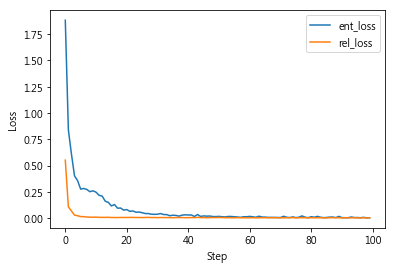

In [12]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.plot(all_ent_loss[:100], label='ent_loss')
plt.plot(all_rel_loss[:100], label='rel_loss')
plt.xlabel("Step")
plt.ylabel("Loss") 
plt.legend()
plt.show()

In [13]:
import random
def random_choose(input_var):
    r_choose = []
    for i in range(BATCH_SIZE):
        r_choose.append(random.randint(0,len(input_var)))
    return r_choose
        
def ent_argmax(output, batchsize):
    output = output.view(batchsize,MAX_LEN,ent_size).argmax(2)
    return output

def rel_argmax(output, batchsize):
    output = output.view(batchsize,MAX_LEN,MAX_LEN,rel_size).argmax(3)
    return output

In [14]:
# Check predictions after training
with torch.no_grad():
    r_choose = random_choose(input_var)
    model.eval()
    ent_output, rel_output = model(input_var[r_choose].cuda() if USE_CUDA else input_var)
    
    batchsize = input_var[r_choose].size(0)
    
    ent_loss = criterion_tag(ent_output.cpu(), ent_var[r_choose].view(BATCH_SIZE*MAX_LEN))
    ent_output = ent_argmax(ent_output, batchsize)
    
    rel_loss = criterion_rel(rel_output.cpu(), rel_var[r_choose].view(BATCH_SIZE*MAX_LEN*MAX_LEN))
    
    
#     print('predict :', ent_output[0])
#     print('true :', ent_var[r_choose[0]])
    print()
    print('predict :', index2tag(ent_output[0], ix_to_ent_tag))
    print('true :', index2tag(ent_var[r_choose[0]], ix_to_ent_tag))
    print()
    print('===================================================')
    print()
    print()
    print('predict :', index2tag(ent_output[1], ix_to_ent_tag))
    print('true :', index2tag(ent_var[r_choose[1]], ix_to_ent_tag))
    
    print()
    print("Entity loss : %.4f" % ent_loss)
    print("Relation loss : %.4f" % rel_loss)


predict : ['O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
true : ['O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',

In [15]:
with torch.no_grad():
    r_choose = random_choose(input_dev)

    model.eval()
    ent_output, rel_output = model(input_dev[r_choose].cuda() if USE_CUDA else input_dev)
    
    batchsize = input_dev[r_choose].size(0)
    
    ent_loss = criterion_tag(ent_output.cpu(), ent_dev[r_choose].view(batchsize*MAX_LEN))
    ent_output = ent_argmax(ent_output, batchsize)
    
    rel_loss = criterion_rel(rel_output.cpu(), rel_var[r_choose].view(batchsize*MAX_LEN*MAX_LEN))
    
    print(r_choose[0])
    print()
    print('predict :', index2tag(ent_output[0], ix_to_ent_tag))
    print()
    print('true :', index2tag(ent_dev[r_choose[0]], ix_to_ent_tag))
    print()

    print("Entity loss : %.4f" % ent_loss)
    print("Relation loss : %.4f" % rel_loss)

6

predict : ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '<PAD>']

true : ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'

In [223]:
from sklearn.metrics import precision_recall_fscore_support


# entity分數 B開頭才算，整個entity一起算  I開頭忽略
# 每個epoch print recall validation 
# 之後可做，自動標rel

def batch_decode(ent_output, rel_output, batch_index, word_lists, true_ent, true_rel):
    rel_lists = []
    true_rel_lists = []
    combine_ent_outputs, combine_ent_trues = [], []
    combine_rel_outputs, combine_rel_trues = [], []
    total_score_outputs, total_score_trues = [], []
    er_score_outputs, er_score_trues = [], []

    #================
    
    
    for e,r,i,te,tr in zip(ent_output, rel_output, batch_index, true_ent, true_rel):
        
        # 算句子長度
        len_of_list = len(word_lists[i])
        word_list = word_lists[i]
        true_ent = index2tag(te, ix_to_ent_tag)[:len_of_list]
        pridict_ent = index2tag(e, ix_to_ent_tag)[:len_of_list]
       
        
        # 單句decode關係
        true_r_list, appear_error = decode_rel(te, tr)   # true
        r_list, appear_error = decode_rel(e, r)          # predict
        
        true_r_list = [list(set(i)) if type(i) is list else i for i in true_r_list]
        r_list = [list(set(i)) if type(i) is list else i for i in r_list]
        
        # 出現error，跳過這句
        if appear_error:
            continue
            
        true_rel_lists.append(true_r_list)
        rel_lists.append(r_list)
        
        true_r_list = true_r_list[:len_of_list]
        r_list = r_list[:len_of_list]
        
        
        print(word_list)
        print(true_ent)
        print(true_r_list)

        print()
        print('Predict output')
        print(pridict_ent)
        print(r_list)
        print()
        
        # In units of entity
        e_t_list, e_p_list = entity_score(true_ent, pridict_ent)  
        er_true, er_pred = ent_and_rel_score(true_r_list, r_list, true_ent, pridict_ent)
        print("=====================================")
        
        # 重新組成跟input data同樣的形式
        for word in range(len_of_list):
            # ============predict======================
            add_r = ''
            if type(r_list[word]) is list: 
                for single_r in r_list[word]:
                    add_r = add_r+single_r+' '
            combine_rel_outputs.append(word_list[word]+' '+pridict_ent[word]+' '+add_r)
            total_score_outputs.append(pridict_ent[word]+' '+add_r)
            
            # ==================true===================
            add_r = ''
            if type(true_r_list[word]) is list:     
                for single_r in true_r_list[word]:
                    try :
                        add_r = add_r+single_r+' '
                    except TypeError:
                        add_r = add_r+' '
                    
            combine_rel_trues.append(word_list[word]+' '+true_ent[word]+' '+add_r)
            total_score_trues.append(true_ent[word]+' '+add_r)
            
                  
        # 斷句用空格
        combine_rel_outputs.append(" ")
        combine_rel_trues.append(" ")
        
        combine_ent_outputs.extend(e_p_list)   
        combine_ent_trues.extend(e_t_list)
        
        er_score_outputs.extend(er_pred) 
        er_score_trues.extend(er_true)  

        
    
    filter_t_o, filter_t_t = filter_all_O(total_score_outputs, total_score_trues)  
    
    # 過濾 O tag的 index
    f_ix = filter_otag(combine_rel_trues)
    
    filter_rel_true = list(combine_rel_trues[i] for i in f_ix)
    filter_rel_output = list(combine_rel_outputs[i] for i in f_ix)
    
    print()
    print('Batch entity score')
    print("%s \t %s \t %s \t" % ('precision ', 'recall ', 'fbeta_score '))
    print(precision_recall_fscore_support(combine_ent_trues, combine_ent_outputs, average='micro',\
                                         labels=np.unique(combine_ent_trues)))    

    print()
    print('Batch relation score')
    print("%s \t %s \t %s \t" % ('precision ', 'recall ', 'fbeta_score '))
    print(precision_recall_fscore_support(filter_rel_true, filter_rel_output, average='micro', \
                                          labels=np.unique(filter_rel_true)))        
    
#     print()
#     print('Batch total score')
#     print("%s \t %s \t %s \t" % ('precision ', 'recall ', 'fbeta_score '))
#     print(precision_recall_fscore_support(filter_t_t, filter_t_o, average='macro', \
#                                          labels=np.unique(filter_t_o)))   
    
    
    er_score_remove = er_score_trues.copy()
    
    try:
        er_score_remove.remove('Something')
    except ValueError:
        pass
    print()
    print('Batch total score')
    print("%s \t %s \t %s \t" % ('precision ', 'recall ', 'fbeta_score '))
    print(precision_recall_fscore_support(er_score_trues, er_score_outputs, average='micro', \
                                         labels=np.unique(er_score_remove)))   
    
    
#     return combine_ent_trues, combine_ent_outputs, filter_rel_true, filter_rel_output, \
#            filter_t_t, filter_t_o
    return combine_ent_trues, combine_ent_outputs, filter_rel_true, filter_rel_output, \
           er_score_trues, er_score_outputs

    

    
def create_rel_info(ent_output):
    r_list = []     # 存放完整關係
    r_dict = {}     # 記錄關係資訊
    appear_error = False

    pred_ent = index2tag(ent_output, ix_to_ent_tag)
    

    e_loc = 0       # 當前遇到的entity的位置
    for loc, e in enumerate(pred_ent):
        if e[0]=='B':
            e_loc = loc
            r_dict[loc] = {
                '_2ndtag':e[2:],
                'end':loc,
            }
            r_list.append([])
                   
        elif e[0]=='I':
            # 錯誤來自於，entity預測錯誤，沒有預測到B tag，直接跳到I tag
            # 所以沒有紀錄e_loc
            try: 
                r_dict[e_loc]['end'] = loc
            except KeyError:
                appear_error = True
                break
            
            r_list.append([])
            
        else:
            r_list.append("")
              
    return r_list, r_dict, appear_error



def decode_rel(ent_output, rel_output):

    r_list, r_dict, appear_error = create_rel_info(ent_output) 
    
    IsB = False           # 是否遇到B tag的lock
    IsNext = False        # 是否為B tag後面的tag 的lock
    num_reocrd = -1       # 紀錄pair數
    now_loc = 0
    pre_rel_end_loc = 0
    now_rel_end_loc = 0
    
    rel_keyerror = False
    
    for now in range(len(rel_output)):
        for loc, rel in enumerate(rel_output[now][:now+1]):
            rel = rel.cpu().numpy()
            
#             print(rel, IsB, IsNext)
            
            # 有關係存在，且為B tag 
            if rel!=rel_tag_to_ix[REL_NONE] and IsB==False and IsNext==False:

                IsB = True
                IsNext = True
                tag = ix_to_rel_tag[int(rel)]
                num_reocrd+=1
                now_loc = loc
                
                # 錯誤來自於，now_loc找不到，也就是說，rel預測出來是有關係存在
                # 但預測是'O'
                # 而在entity中卻沒有預測出來，所以r_dict中沒有紀錄
                try:
                    pre_rel_end_loc = r_dict[now_loc]['end']

                except KeyError:
                    rel_keyerror = True
                    break
                    
                
                try:
                    now_rel_end_loc = r_dict[now]['end']
                    
                except KeyError:
                    rel_keyerror = True
                    break
            
             
                second_tag = r_dict[now_loc]['_2ndtag']
                # check_loc 之後有多關係出現時要更改
                preAorB = check_loc(second_tag)
                nowAorB = 'B' if preAorB=='A' else 'A'
                
                pre_complete_rel = tag+"-"+str(num_reocrd)+"-"+preAorB
                now_complete_rel = tag+"-"+str(num_reocrd)+"-"+nowAorB
                
                # 將以前的token填上關係
                for token in range(now_loc, pre_rel_end_loc+1):
                    
                    # 出現以下error
                    '''AttributeError: 'str' object has no attribute 'append'''
                    # 為 r_list 前處理中沒有給予可能有關係的位置空的list
                    try:
                        r_list[token].append(pre_complete_rel)
                    except AttributeError:
                        r_list[token] = []
                        r_list[token].append(pre_complete_rel)

             
                # 當前token填上關係
                r_list[now].append(now_complete_rel)
                

            
            # 關係前位中B tag後面的tag
            elif rel!=rel_tag_to_ix[REL_NONE] and IsB:
                # 如果還在這個entity的範圍內
                if loc<=pre_rel_end_loc:
                    pass
                
                # 超出現在這個entity的範圍，改lock
                else:
                    IsB = False

            
            # B tag後面的tag的關係，依照前面的關係複製
            elif rel!=rel_tag_to_ix[REL_NONE] and IsNext:
                r_list[now] = r_list[now-1]
                
                
            else:
                if now<=now_rel_end_loc:
                    IsB = False
                else:
                    IsB = False
                    IsNext = False

        
        if rel_keyerror:
            rel_keyerror = False
            break
                
                
    return r_list, appear_error
                

# 是三元關係中的前者還是後者                
# 有多種關係資料後這段要改
def check_loc(second_tag):
    if second_tag in rule[0]:
        return 'A'
    elif second_tag in rule[2]:
        return 'B'
    
    
def filter_otag(combine_trues):
    ix2eval = []
    
    for i, token in enumerate(combine_trues):
        # error : string index out of range
        # 出現空白(斷句)
        try :
            token[2]!='O'
        except IndexError:
            continue
        else:
            if token[2]!='O':
                ix2eval.append(i)
            
    return ix2eval

def filter_all_O(total_score_outputs, total_score_trues):
    
    filter_t_o, filter_t_t = [], []                  # filter total outputs and trues
    for pred, true in zip(total_score_outputs, total_score_trues):
        if pred=='O ' and true=='O ':
            pass
        else:
            filter_t_o.append(pred)
            filter_t_t.append(true)
    
    return filter_t_o, filter_t_t
            

def entity_score(true_ent, pridict_ent):
    e_ix = {}
    now_e = 0
    B_lock = False
    for i, e in enumerate(true_ent):
        if e[0]=='B' and B_lock==False:
            e_ix[i] = {'end':i}
            B_lock = True
            now_e = i
            
        elif e[0]=='I':
            e_ix[now_e]['end'] = i
            
        elif e[0]=='B' and B_lock==True:
            e_ix[now_e]['end'] = i-1
            e_ix[i] = {'end':i}
            now_e = i
            
        elif e[0]=='O':
            B_lock = False
    
    
    e_t_list = []   #entity true list
    e_p_list = []   #predict
    
    for start in e_ix:
        e_end = e_ix[start]['end']
        e_t_list.append("".join(true_ent[start:e_end+1]))
        e_p_list.append("".join(pridict_ent[start:e_end+1]))
    
    
    error_e = []
    
    for i, e in enumerate(pridict_ent):
        to_continue = False
        if e[0]!='O':
            
            # dict 無順序性
            for start in e_ix:
                if i>=start and i<= e_ix[start]['end']:
                    to_continue = True
                    break
                    
            if to_continue == True:
                continue
            else:
                error_e.append(e)
                
    
    # combine error tag
    error_tag_check = False
    record_tag = ''
    new_error_e = []
    for i, error_tag in enumerate(error_e):
        if error_tag[0]=="B" and error_tag_check==False:
            error_tag_check=True
            record_tag = error_tag
            
        elif i==len(error_e)-1:
            record_tag += error_tag
            new_error_e.append(record_tag)
        
        elif error_tag[0]=="I" and error_tag_check==True:
            record_tag += error_tag
            
        
        elif error_tag[0]=="B" and error_tag_check==True:
            error_tag_check=False
            new_error_e.append(record_tag)
            record_tag = error_tag
                    
    
    e_t_list.extend(['O' for i in range(len(new_error_e))])
    e_p_list.extend(new_error_e)
    
    return e_t_list, e_p_list
        

def ent_and_rel_score(true_r_list, r_list, true_ent, pridict_ent):
    
    max_pair = 0
    for r in true_r_list:
        if type(r) is list:
            for single_r in r:
                if int(single_r[-3])>max_pair:
                    max_pair = int(single_r[-3])
    
    record_loc = {}
    for i in range(max_pair+1):
         for loc, r in enumerate(true_r_list):
            if type(r) is list:
                for single_r in r:
                    if int(single_r[-3])==i and i not in record_loc:
                        record_loc[i] = [loc]
                    
                    elif int(single_r[-3])==i and i in record_loc:
                        record_loc[i].append(loc)
    

    # 紀錄同 pair 全部位置
    '''record_loc: {0: [24, 25, 26, 27, 35, 36]}'''
    er_true = []
    er_pred = []
    # 同個 pair 一定同個關係
    # 所以只要找entity是否都一樣
    for k in record_loc:
        pair_ent_true = [true_ent[i] for i in record_loc[k]]
        pair_ent_pred = [pridict_ent[i] for i in record_loc[k]]
        
        pair_rel_true = get_one_rel(true_r_list, record_loc, k)
        pair_rel_pred = get_one_rel(r_list, record_loc, k)       
        
        process_rel_true = "".join(["".join(r) for r in pair_rel_true])
        process_rel_pred = "".join(["".join(r) for r in pair_rel_pred])
        
        combine_er_true = "".join(pair_ent_true) + process_rel_true
        combine_er_pred = "".join(pair_ent_pred) + process_rel_pred
        
        er_true.append(combine_er_true)
        er_pred.append(combine_er_pred)
    
    # predict有東西出現
    # 但true的rel全部沒東西
    
    error_pred = []
    all_none = True
    if not er_true and not er_pred:
        for r in r_list:
            if r!='' and r!=[]:
                error_pred.extend(r)
                all_none = False
                
        if all_none == True:
            er_true = [" "]
            er_pred = [" "]
        else:
            er_true = ['Something']
            er_pred = [''.join(error_pred)]
    
    print(er_true)
    print(er_pred)

    
    return er_true, er_pred


def get_one_rel(r_list, record_loc, key):
    
    new_pair_rel = []
    pair_rel = [r_list[i] for i in record_loc[key]]
    
    for r in pair_rel:
        for single_r in r:
            if single_r[-3]==str(key):
                new_pair_rel.append(single_r)
    
    return new_pair_rel

In [224]:
import warnings
warnings.filterwarnings('always') 

ent_predicts, ent_trues = [], []
rel_predicts, rel_trues = [], []
total_predicts, total_trues = [], []

with torch.no_grad():
    for step, (batch_x, batch_ent, batch_rel, batch_index) in enumerate(dev_loader):
        model.eval()
        ent_output, rel_output = model(batch_x.cuda() if USE_CUDA else batch_x)
        
        batchsize = batch_x.size(0)
        
        ent_loss = criterion_tag(ent_output.cpu(), batch_ent.view(batchsize*MAX_LEN))
        ent_output = ent_argmax(ent_output, batchsize)
        
        rel_loss = criterion_rel(rel_output.cpu(), batch_rel.view(batchsize*MAX_LEN*MAX_LEN))
        rel_output = rel_argmax(rel_output, batchsize)
    
        print()    
        print("Entity loss : %.4f" % ent_loss)
        print("Relation loss : %.4f" % rel_loss)
        print()
        
        combine_ent_trues, combine_ent_outputs, filter_rel_true, filter_rel_output, filter_t_t, filter_t_o = \
        batch_decode(ent_output, rel_output, batch_index, raw_input_dev, batch_ent, batch_rel)
             
        
        # total ent score
        ent_predicts.extend(combine_ent_outputs)
        ent_trues.extend(combine_ent_trues)
        
        # total rel score
        rel_predicts.extend(filter_rel_output)
        rel_trues.extend(filter_rel_true)
        
        # total score
        total_predicts.extend(filter_t_o)
        total_trues.extend(filter_t_t)
        
        
        
        print()
        print('==========================')
        print('==========================')
        print()
    
    print()
    
    print("Total entity score")
    print("%s \t %s \t %s \t" % ('precision ', 'recall ', 'fbeta_score '))
    print(precision_recall_fscore_support(ent_trues, ent_predicts, average='micro', \
                                         labels=np.unique(ent_trues))) 
    print()
    
    
    print("Total relation score")
    print("%s \t %s \t %s \t" % ('precision ', 'recall ', 'fbeta_score '))
    print(precision_recall_fscore_support(rel_trues, rel_predicts, average='micro', \
                                          labels=np.unique(rel_trues)))   
    print()
    
    
    total_remove = total_trues.copy()
    try:
        total_remove.remove('Something')
    except ValueError:
        pass
    print("Total entity+relation score")
    print("%s \t %s \t %s \t" % ('precision ', 'recall ', 'fbeta_score '))
    print(precision_recall_fscore_support(total_trues, total_predicts, average='micro', \
                                         labels=np.unique(total_remove)))       


Entity loss : 0.0554
Relation loss : 0.0016

['高', '效', '保', '濕', '，', '舒', '緩', '肌', '膚', '，', '溫', '和', '修', '復', '，', '重', '塑', '晶', '透', '的', '的', '亮', '顏', '全', '效', '保', '濕', '，', '改', '善', '乾', '性', '肌', '膚', '問', '題', '，', '使', '肌', '膚', '亮', '透', '有', '光', '澤']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'B-STAT', 'I-STA

['補', '充', '說', '明', ',', '因', '為', '我', '本', '身', '肌', '膚', '屬', '於', '敏', '感', '性', '肌', '膚', ',', '用', '此', '款', '面', '膜', '不', '會', '過', '敏', '喔', '~', '~', '而', '且', '保', '濕', '效', '果', '很', '強', '喔', '~', '^', '^']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O'

['適', '用', '族', '群', '為', '乾', '燥', '肌', '、', '缺', '水', '保', '濕', '、', '2', '5', '歲', '以', '上', '肌', '膚']
['O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', [], [], [], '', '', '', [], [], '', '', '', '', '', '', '', '']

['B-STATI-STATI-STATB-FUNCI-FUNCApplyTo-0-BApplyTo-0-BApplyTo-0-BApplyTo-0-AApplyTo-0-A']
['B-STATI-STATI-STATB-FUNCI-FUNC']
['效', '果', '方', '面', '我', '覺', '得', '還', '不', '錯', ',', '因', '為', '我', '是', '混', '合', '性', '肌', '膚', ',', '敷', '完', '了', '之', '後', '有', '覺', '得', '還', '滿', '保', '濕', '的', ',', '隔', '天', '早', '上', '起', '來', '比', '較', '會', '出', '油', '的', '地', '方', ',', '出',

['皮', '珂', '兒', '是', '韓', '國', '製', '造', '的', '保', '養', '品', '，', '有', '可', '愛', '的', '火', '山', '插', '圖', '，', '鐵', '罐', '包', '裝', '，', '是', '很', '特', '殊', '的', '慕', '絲', '質', '地', '，', '需', '沖', '洗', '的', '清', '潔', '面', '膜', '，', '很', '適', '合', '油', '性', '肌', '膚', '來', '使', '用']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '

['本', '身', '是', '極', '乾', '的', '膚', '質', ',', '常', '需', '要', '加', '強', '保', '濕']
['O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', [], [], [], [], '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC']
['', '', '', '', [], [], [], [], '', '', '', '', '', '', [], []]

[' ']
[' ']
['夏', '日', '將', '到', '了', '，', '保', '濕', '不', '是', '只', '有', '在', '冬', '天', '，', '夏', '天', '會', '常', '常', '待', '在', '冷', '氣', '房', '，', '所', '以', '保', '濕', '還', '是', '很', '重', '要', '，', '而', '這', '面', '膜', '對', '於', '乾', '燥', '的', '肌', '膚', '急', '救', '補', '水', '效', '果', '還', '挺', '讓', '人', '滿', '意', '的']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STA

['“', '酵', '母', '萃', '取', '”', '搭', '配', '“', '小', '分', '子', '玻', '尿', '酸', '”', '及', '“', '牛', '奶', '蛋', '白', '”', '使', '乾', '燥', '肌', '膚', '充', '滿', '水', '分', '，', '長', '效', '保', '濕']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A']]

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], '', '', '', '', '', '', ''

['不', '過', '每', '次', '敷', '完', '臉', ',', '保', '濕', '的', '效', '果', '非', '常', '好', ',', '因', '為', '是', '敏', '感', '膚', '質', ',', '有', '時', '候', '臉', '上', '會', '有', '過', '敏', '現', '象', ',']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', '']


In [89]:
test_data = root+'facial_r2.test'
input_test, ent_test, rel_test, raw_index_test, raw_input_test = dev_preprocess(test_data)
test_loader = dataload(input_test, ent_test, rel_test, raw_index_test)

In [91]:
ent_predicts, ent_trues = [], []
rel_predicts, rel_trues = [], []
total_predicts, total_trues = [], []

with torch.no_grad():
    for step, (batch_x, batch_ent, batch_rel, batch_index) in enumerate(test_loader):
        model.eval()
        ent_output, rel_output = model(batch_x.cuda() if USE_CUDA else batch_x)
        
        batchsize = batch_x.size(0)
        
        ent_loss = criterion_tag(ent_output.cpu(), batch_ent.view(batchsize*MAX_LEN))
        ent_output = ent_argmax(ent_output, batchsize)
        
        rel_loss = criterion_rel(rel_output.cpu(), batch_rel.view(batchsize*MAX_LEN*MAX_LEN))
        rel_output = rel_argmax(rel_output, batchsize)
    
        print()
        
        print("Entity loss : %.4f" % ent_loss)
        print("Relation loss : %.4f" % rel_loss)
        print()
        
        combine_ent_trues, combine_ent_outputs, filter_rel_true, filter_rel_output, filter_t_t, filter_t_o = \
        batch_decode(ent_output, rel_output, batch_index, raw_input_test, batch_ent, batch_rel)
             
        
        # total ent score
        ent_predicts.extend(combine_ent_outputs)
        ent_trues.extend(combine_ent_trues)
        
        # total rel score
        rel_predicts.extend(filter_rel_output)
        rel_trues.extend(filter_rel_true)
        
        # total score
        total_predicts.extend(filter_t_o)
        total_trues.extend(filter_t_t)
        
        
        
        print()
        print('==========================')
        print('==========================')
        print()
    
    print()
    
    print("Total entity score")
    print("%s \t %s \t %s \t" % ('precision ', 'recall ', 'fbeta_score '))
    print(precision_recall_fscore_support(ent_trues, ent_predicts, average='weighted', )) 
    print()
    
    
    print("Total relation score")
    print("%s \t %s \t %s \t" % ('precision ', 'recall ', 'fbeta_score '))
    print(precision_recall_fscore_support(rel_trues, rel_predicts, average='micro', \
                                          labels=np.unique(rel_predicts)))   
    print()
    
    print("Total entity+relation score")
    print("%s \t %s \t %s \t" % ('precision ', 'recall ', 'fbeta_score '))     
    print(precision_recall_fscore_support(total_trues, total_predicts, average='macro', \
                                          labels=np.unique(total_predicts)))   


Entity loss : 0.0677
Relation loss : 0.0013

['這', '次', '試', '用', '的', '保', '濕', '凝', '露', '強', '調', '敏', '感', '肌', '膚', '也', '適', '用', '，', '不', '含', '防', '腐', '劑', '與', '酒', '精', '，', '確', '實', '使', '用', '後', '不', '會', '長', '痘', '痘', '也', '沒', '有', '冒', '粉', '刺', '，', '凝', '露', '是', '乳', '白', '色', '的', '，', '非', '常', '的', '水', '，', '沒', '有', '任', '何', '味', '道', '，']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O',

['擦', '上', '後', '，', '肌', '膚', '馬', '上', '可', '以', '立', '即', '感', '受', '到', '很', '水', '潤', '、', '保', '濕', '的', '觸', '感', '；', '又', '有', '玫', '瑰', '果', '油', '、', '接', '骨', '木', '油', '給', '予', '肌', '膚', '滋', '潤', '，', '讓', '皮', '膚', '乾', '燥', '缺', '水', '的', '狀', '況', '可', '以', '改', '善']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',

['此', '粉', '底', '液', '還', '遮', '瑕', '度', '還', '蠻', '好', '的', ',', '所', '以', '相', '對', '妝', '感', '就', '重', '了', '點', ',', '質', '地', '方', '面', '還', '蠻', '像', '精', '華', '液', '的', ',', '非', '常', '柔', '滑', '好', '推', '均', ',', '但', '是', '會', '卡', '粉', '且', '有', '點', '乾', '(', '我', '是', '油', '性', '肌', ')', ',', '向', '在', '目', '前', '秋', '季', '使', '用', ',', '我', '一', '定', '要', '再', '妝', '前', '擦', '上', '高', '保', '濕', ',', '感', '覺', '才', '不', '會', '有', '乾', '的', '感', '覺']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', 

['保', '濕', '對', '我', '來', '說', '可', '以', ',', '混', '合', '肌', '的', '我', '再', '擦', '點', '乳', '液', '就', '夠']
['B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '']

Predict output
['B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '']

['B-FUNCI-FUNC', 'B-STATI-STATI-STAT']
['B-FUNCI-FUNC', 'B-STATI-STATI-STAT']
yo
[['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '']
[['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['Ap

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


['因', '為', '我', '是', '油', '性', '肌', '.', '.', '這', '瓶', '我', '用', '我', '覺', '得', '保', '濕', '也', '夠', '.', '.', '也', '不', '需', '要', '在', '擦', '別', '的']
['O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', [], [], [], '', '', '', '', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '', '']

['B-FUNCI-FUNC', 'B-STATI-STATI-STAT']
['B-FUNCI-FUNC', 'B-STATI-STATI-STAT']
yo
['', '', '', '', [], [], [], '', '', '', '', '', '', '', '', '', [], [], '', '', '', '', '',

['前', '陣', '子', '皮', '膚', '過', '敏', '結', '果', '留', '下', '痕', '跡', '剛', '好', '收', '到', '這', '組', '商', '品', '主', '打', '美', '白', '真', '是', '開', '心', '打', '開', '包', '裝', '首', '先', '就', '先', '加', '分', '了', '，', '封', '口', '處', '還', '有', '一', '層', '防', '止', '化', '妝', '水', '流', '出', '的', '貼', '紙']
['O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC'

['乾', '性', '肌', '膚', '的', '人', '在', '夏', '天', '擦', '還', '滿', '適', '合', '的', '，', '滿', '保', '濕', '的', '也', '不', '會', '太', '乾', '，', '滋', '潤', '且', '不', '黏', '膩']
['B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[[], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '', '', '']

['B-STATI-STATI-STATI-STAT', 'B-FUNCI-FUNC']
['B-STATI-STATI-STATI-STAT', 'B-FUNCI-FUNC']
yo
[[], [], []

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)



Entity loss : 0.0513
Relation loss : 0.0011

['粉', '底', '液', '我', '一', '定', '會', '找', '有', '保', '濕', '成', '分', '在', '裡', '面', ',', '因', '為', '我', '的', '皮', '膚', '是', '乾', '肌']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], []]

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT']
['', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B']]

['B-STATI-STAT', 'O', 'O']
['B-STATI-STAT', 'B-FUNC', 'I-FUNC']
yo
['', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B']]
['', '', '', '', '', '', '',

['沒', '有', '添', '加', '酒', '精', '及', '香', '料', ',', '在', '這', '個', '季', '節', '交', '換', '變', '化', '之', '際', '用', '起', '來', '覺', '得', '很', '舒', '服', ',', '原', '本', '每', '年', '天', '氣', '變', '冷', '會', '有', '些', '小', '脫', '皮', '的', '皮', '膚', '也', '安', '定', '很', '多', ',', '就', '我', '油', '性', '肌', '膚', '來', '說', '秋', '冬', '使', '用', '真', '的', '很', '剛', '好', ',', '皮', '膚', '也', '不', '太', '會', '出', '油', ',', '以', '基', '礎', '保', '養', '而', '言', '我', '覺', '得', 'C', '/', 'P', '值', '很', '高']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '',

['我', '是', '混', '合', '性', '肌', '膚', '歐', '(', '乾', '乾', '有', '皮', '削', '的', '皮', '膚', '，', '等', '會', '兒', '看', '保', '濕', '情', '況', ')']
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O']
['', '', [], [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], '', '', '']

Predict output
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O']
['', '', [], [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], '', '', '']

['B-STATI-STATI-STATI-STATI-STAT', 'B-FUNCI-FUNC']
['B-STATI-STATI-STATI-STATI-STAT', 'B-FUNCI-FUNC']
yo
['', '', [], [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], '', '', '']
['', '', [], [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', 

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


['本', '身', '是', '乾', '性', '肌', ',', '些', '微', '泛', '紅', ',', '後', '續', '仍', '要', '加', '上', '保', '濕', '產', '品']
['O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O']
['', '', '', [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', [], [], '', '']

Predict output
['O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O']
['', '', '', [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', [], [], '', '']

['B-FUNCI-FUNC', 'B-STATI-STATI-STAT']
['B-FUNCI-FUNC', 'B-STATI-STATI-STAT']
yo
['', '', '', [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', [], [], '', '']
['', '', '', [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', [], [], '', '']
yoyo
['這', '次', '試', '用', '的', 'L', 'a', 'g', 'i', 'n', 'a', '氨', '基', '酸', '洗', '顏', '慕', '斯', '，', '訴', '求', '溫', '和', '洗', '淨', '，', '保', '濕', '不', '緊', '繃', '，

['更', '是', '敏', '感', '肌', '膚', '的', '保', '養', '利', '器', '，', '雷', '射', '後', '不', '需', '購', '買', '店', '家', '推', '銷', '的', '醫', '美', '產', '品']
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', [], [], [], [], '', [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

['B-STATI-STATI-STATI-STAT', 'B-FUNCI-FUNC']
['B-STATI-STATI-STATI-STAT', 'B-FUNCI-FUNC']
yo
['', '', [], [], [], [], '', [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''

['保', '濕', '度', '普', '普', '但', '冬', '天', '中', '乾', '性', '膚', '質', '可', '能', '需', '要', '再', '搭', '配', '乳', '液']
['B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[[], [], [], '', '', '', '', '', '', [], [], [], [], '', '', '', '', '', '', '', '', '']

Predict output
['B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[['ApplyTo-0-A'], ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '']

['B-FUNCI-FUNCI-FUNC', 'B-STATI-STATI-STATI-STAT']
['B-FUNCI-FUNCI-FUNC', 'B-STATI-STATI-STATI-STAT']
yo
[['ApplyTo-0-A'], ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '']
[[], [], [], '', '', '', '

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


['V', 'I', 'C', 'H', 'Y', '薇', '姿', '智', '慧', '動', '能', '保', '濕', '精', '華', '，', '乾', '荒', '肌', '的', '救', '星']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '', '']

['B-STATI-STATI-STAT', 'O', 'O']
['OOO', 'B-FUNC', 'I-FUNC']
yo
['', '', '', '', '', '', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '', '']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], '', '', '']
yoyo
['使', '用', '後', '馬', '上', '會', '感', '受', '到', '敏', '感', '肌', '膚', '鎮', '定', '舒', '緩', '下', '來', '，', '泛', '紅', '等', '狀', '況', '瞬', '間', '消', '退', '不', '少', '，', '且', '沒', '有', '其', '它', '保', '養', '品',

['今', '天', '試', '用', '的', '是', 'C', 'H', 'I', 'S', 'A', '肌', '莎', '賦', '活', '調', '理', '水', '潤', '凝', '乳', '，', '這', '款', '調', '理', '乳', '重', '點', '放', '在', '強', '化', '保', '濕', '效', '果', '及', '適', '用', '於', '敏', '感', '肌', '的', '女', '孩', '們']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '',

['卸', '妝', '液', '含', '有', '水', '蓮', '精', '華', '與', 'V', 'i', 't', 'B', '5', '可', '以', '保', '濕', '修', '護', '肌', '膚', ',', '連', '敏', '感', '性', '肌', '膚', '也', '適', '用', ',']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)



Entity loss : 0.0573
Relation loss : 0.0015

['我', '是', '混', '合', '肌', '.', '.', '.', '最', '怕', '使', '用', '保', '濕', '的', '東', '西', '.', '.', '油', '油', '又', '黏', '黏', '的', '.', '.']
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', [], [], [], '', '', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '', '', '']

['B-STATI-STATI-STAT']
['B-STATI-STATI-STAT']
yo
['', '', [], [], [], '', '', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '', '', '']
['', '', [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
yoyo

['滿', '意', '.', '.', '滿', '意', '滋', '潤', '了', '冬', '天', '乾', '燥', '的', '肌', '膚', '讓', '臉', '頰', '容', '易', '保', '濕', '有', '水', '嫩', '的', '感', '覺', '質', '地', '細', '緻', '好', '推', '展', '吸', '收', '迅', '速', '不', '會', '因', '為', '多', '一', '層', '保', '養', '程', '序', '而', '費', '時', '呈', '現', '的', '效', '果', '很', '符', '合', '產', '品', '訴', '求', '的', '重', '點', '值', '得', '列', '入', '保', '養', '品', '的', '購', '買', '清', '單']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', ['A

['所', '以', '對', '乾', '燥', '敏', '感', '型', '肌', '膚', '使', '用', '後', '的', '確', '感', '覺', '不', '會', '有', '負', '擔', '，', '兼', '具', '保', '養', '、', '底', '妝', '、', '防', '曬', '的', '功', '能', '，', '效', '果', '還', '滿', '自', '然', '，', '保', '濕', '感', '也', '滿', '持', '久', '的', '，', '但', 'T', '字', '卻', '還', '是', '會', '有', '點', '小', '小', '的', '油', '感', '，', '但', '整', '體', '來', '說', '，', '產', '品', '效', '果', '滿', '好', '的']
['O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '', '',

['個', '人', '覺', '得', '很', '保', '濕', '~', '~', '之', '後', '所', '擦', '的', '保', '養', '品', '~', '都', '不', '會', '感', '覺', '皮', '膚', '乾', '燥']
['O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT']
['', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B']]

Predict output
['O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT']
['', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', [], [], '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], []]

['B-FUNCI-FUNC', 'B-STATI-STATI-STATI-STAT']
['B-FUNCI-FUNC', 'B-STATI-STATI-STATI-STAT']
yo
['', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)



Entity loss : 0.0576
Relation loss : 0.0012

['通', '常', '洗', '完', '臉', '，', '擦', '乾', '後', '都', '很', '容', '易', '開', '始', '皮', '膚', '乾', '燥', '，', '必', '須', '要', '趕', '快', '擦', '上', '保', '養', '品', ',', 'l', 'a', 'g', 'i', 'n', 'a', '這', '一', '款', '洗', '完', '雖', '然', '因', '為', '滑', '滑', '的', '感', '覺', '讓', '我', '比', '較', '不', '緊', '繃', ',', '但', '是', '說', '到', '保', '濕', '的', '程', '度', '我', '覺', '得', '很', '普', '通', '就', '是', '.', '.', '.', '還', '是', '必', '須', '要', '盡', '快', '擦', '上', '保', '濕', '保', '養', '品']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['

['優', '點', '：', '很', '好', '推', '，', '延', '展', '性', '也', '很', '好', '，', '也', '不', '黏', '膩', '，', '吸', '收', '程', '度', '很', '好', '，', '很', '快', '就', '推', '進', '去', '的', '感', '覺', '，', '擦', '完', '後', '，', '摸', '起', '來', '很', '好', '摸', '，', '很', '柔', '嫩', '，', '很', '平', '滑', '，', '沒', '有', '剌', '激', '感', '，', '即', '使', '是', '敏', '感', '肌', '也', '可', '以', '使', '用', '喔']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', 

['吸', '收', '後', '有', '舒', '緩', '到', '肌', '膚', '乾', '燥', '情', '形', '，', '當', '下', '立', '即', '保', '濕', '補', '水', '不', '會', '覺', '得', '肌', '膚', '乾', '乾', '繃', '繃', '的']
['O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', ['ApplyTo-0-B', 'ApplyTo-1-B'], ['ApplyTo-0-B', 'ApplyTo-1-B'], ['ApplyTo-0-B', 'ApplyTo-1-B'], ['ApplyTo-0-B', 'ApplyTo-1-B'], '', '', '', '', '', '', '', ['ApplyTo-1-A'], ['ApplyTo-1-A'], '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', [], [], '', [], [], [], [], '', '', '', '', '', '', '', [], [], '', '', '', '', ''

['我', '覺', '得', '會', '是', '乾', '肌', '人', '的', '好', '朋', '友', ',', '很', '保', '濕', '又', '覺', '得', '不', '會', '很', '油', '膩', '~', '我', '很', '喜', '歡']
['O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', [], [], '', '', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '', '', '']

['B-STATI-STAT', 'B-FUNCI-FUNC']
['B-STATI-STAT', 'B-FUNCI-FUNC']
yo
['', '', '', '', '', [], [], '', '', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '', '', '']
['', '', '', '', '', ['ApplyTo-0-

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


['因', '為', '本', '人', '皮', '膚', '是', '屬', '於', '比', '較', '中', '性', '偏', '乾', '敏', '感', '肌', '，', '所', '以', '在', '選', '擇', '保', '養', '品', '最', '怕', '就', '是', '會', '過', '敏', '、', '紅', '腫', '、', '癢', '，', '或', '是', '保', '養', '使', '用', '後', '臉', '部', '呈', '現', '出', '濕', '黏', '的', '狀', '態', '會', '很', '不', '舒', '服']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I

['很', '多', '保', '養', '品', '都', '說', '能', '保', '濕', '，', '同', '樣', '強', '調', '保', '濕', '，', '凱', '薩', '琳', '覺', '得', '水', '之', '妍', '水', '漾', '保', '濕', '精', '華', '露', '的', '特', '點', '是', '它', '是', '專', '門', '為', '缺', '水', '和', '缺', '水', '性', '敏', '感', '膚', '質', '而', '設', '計', '，', '專', '著', '在', '皮', '膚', '的', '補', '水', '、', '保', '水', '和', '鎖', '水', '，', '而', '且', '還', '有', '獨', '家', '的', '配', '方', '“', 'A', 'q', 'u', 'a', 'g', 'e', 'n', 'i', 'u', 'm', '®', '”', '水', '漾', '因', '子']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'

['淡', '化', '斑', '點', '痘', '疤', '、', '緊', '緻', '粗', '大', '毛', '孔', '的', '效', '果', '目', '前', '使', '用', '下', '來', '還', '沒', '有', '太', '大', '的', '改', '變', '，', '目', '前', '對', '於', '這', '樣', '產', '品', '還', '在', '觀', '望', '中', '，', '也', '許', '會', '比', '較', '適', '合', '油', '性', '肌', '膚', '者', '使', '用', '~']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)



Entity loss : 0.0593
Relation loss : 0.0013

['雖', '然', '感', '覺', '質', '地', '有', '點', '厚', '重', '黏', '膩', '(', '因', '為', '我', '是', '混', '合', '肌', '~', '雖', '然', '肌', '膚', '缺', '水', '~', '但', '使', '用', '太', '滋', '潤', '的', '保', '濕', '商', '品', '還', '是', '會', '長', '痘', ')']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', ''

['乾', '肌', '膚', '的', '話', '，', '可', '能', '得', '馬', '上', '加', '上', '其', '他', '的', '乳', '液', '/', '乳', '霜', '等', '保', '濕', '產', '品']
['B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O']
[[], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], '', '']

Predict output
['B-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O']
[[], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], '', '']

['B-STATI-STATI-STAT', 'B-FUNCI-FUNC']
['B-STATI-STATO', 'B-FUNCI-FUNC']
yo
[[], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], '', '']
[[], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], '', '']
yoyo
['以', '我', '本', '身', '混', '合', '肌', '來', '說'

['不', '過', '好', '處', '是', '，', '這', '款', '不', '會', '致', '痘', '，', '我', '覺', '得', '擦', '了', '幾', '天', '，', '或', '許', '達', '到', '舒', '緩', '皮', '膚', '敏', '感', '情', '況', '的', '效', '果', '，']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], [], '', '', '', '', '', '']

['B-STATI-ST

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)



Entity loss : 0.0565
Relation loss : 0.0015

['且', '有', '感', '受', '到', '滋', '潤', '乾', '燥', '肌', '膚', ',', '粗', '糙', '肌', '膚', '也', '慢', '慢', '有', '平', '滑', '柔', '嫩', '的', '效', '果']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O']
['', '', '', '', '', '', '', [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', [], [], '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O']
['', '', '', '', '', '', '', [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', [], [], '', '', '']

['B-FUNCI-FUNC', 'B-STATI-STATI-STATI-STAT']
['B-FUNCI-FUNC', 'B-STATI-STATI-STATI-STAT']
yo
['', '', '', '', '', '', '', [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', [], [], '', '', '']
['', '', '', '', '', '', '', [], [], [], [], '', 

['比', '較', '讓', '我', '失', '望', '的', '是', '保', '濕', '效', '果', '~', '可', '能', '印', '為', '我', '是', '一', '到', '冬', '天', '就', '會', '很', '乾', '的', '混', '合', '性', '肌', '膚', '~']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O']
['', '', '', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], [], '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O']
['', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], [], '']

['B-FUNCI-FUNC', 'B-STATI-STATI-STATI-STATI-STAT

['後', '來', '用', '在', '臉', '上', '，', '一', '開', '始', '有', '一', '點', '點', '灼', '，', '但', '之', '後', '就', '還', '好', '，', '皮', '膚', '有', '感', '覺', '柔', '順', '，', '保', '濕', '效', '果', '很', '好', '，', '對', '於', '混', '合', '性', '肌', '膚', '的', '我', '還', '算', '一', '個', '不', '錯', '的', '選', '擇']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], [], '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUN

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


['整', '體', '來', '說', '是', '一', '項', '不', '錯', '用', '的', '美', '白', '精', '華', '，', '推', '薦', '給', '想', '淡', '化', '痘', '疤', '、', '怕', '油', '膩', '的', '敏', '感', '肌', '使', '用', '，', '3', '0', 'm', 'l', '$', '2', '5', '0', '0', '以', '美', '白', '精', '華', '的', '價', '位', '來', '說', '算', '中', '等', '，', '若', '搭', '配', '特', '惠', '組', '合', '會', '考', '慮', '購', '入', '使', '用']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',

['總', '的', '來', '說', ':', '若', '是', '尋', '求', '淡', '斑', '，', '此', '商', '品', '的', '功', '能', '仍', '有', '待', '應', '證', '，', '但', '是', '就', '乾', '性', '皮', '膚', '來', '說', '，', '保', '濕', '度', '與', '持', '久', '度', '是', '可', '以', '做', '為', '購', '買', '選', '項', '的']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ST

['這', '次', '試', '用', '全', '效', '舒', '緩', '精', '華', '液', '，', '令', '敏', '感', '肌', '的', '我', '很', '滿', '意', '它', '的', '效', '果']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '']

['B-STATI-STATI-STAT', 'O', 'O']
['B-STATI-STATI-STAT', 'B-FUNC', 'I-FUNC']
yo
['', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '']
['', '', '', '', '', '', '', '', '', '', '', '', '', 

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


['這', '瓶', 'D', 'R', '.', 'W', 'U', '超', '彈', '力', '緊', '緻', '精', '華', '露', '真', '得', '很', '好', '用', '耶', '~', '連', '我', '這', '敏', '感', '肌', '膚', '使', '用', '了', '都', '不', '會', '覺', '得', '不', '適', '了', '，', '而', '且', '也', '讓', '臉', '部', '肌', '膚', '有', '光', '澤', '，', '各', '位', '水', '水', '還', '等', '什', '麼', '呢']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O

['這', '款', '保', '濕', '霜', '標', '榜', '專', '為', '敏', '感', '性', '肌', '膚', '而', '設']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O']
['', '', '', '', '', '', '', '', '', [], [], [], [], [], '', '']

Predict output
['O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O']
['', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '']

['B-STATI-STATI-STATI-STATI-STAT', 'O', 'O']
['B-STATI-STATI-STATI-STATI-STAT', 'B-FUNC', 'I-FUNC']
yo
['', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '']
['', '', '', '', '', '', '', '', '', [], [], [], [], [], '', '']
yoyo
['我', '是', '混', '合', '肌', '，', '又', '油', '又', '乾', '，', '雖', '然', '這', '瓶', '還', '算', '好', '吸', '收', '，', '但', '我', '覺', '得', '霜',

['可', '以', '明', '顯', '感', '覺', '到', '有', '改', '善', '到', '乾', '燥', '肌', '膚', '的', '保', '濕', '能', '力']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', [], [], [], [], '', [], [], '', '']

['B-FUNCI-FUNC', 'B-STATI-STATI-STATI-STAT']
['B-FUNCI-FUNC', 'B-STATI-STATI-STATI-STAT']
yo
['', '', '', '', '', '', '', '', '', '', '', [], [], [], [], '', [], [], '', '']
['', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '']
yoyo
['覺', '得', 'f', 'r', 'e', 'e', 'p', 'l', '

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)



Entity loss : 0.0707
Relation loss : 0.0018

['我', '想', '.', '.', '.', '這', '款', '應', '該', '是', '適', '合', '油', '性', '肌', '的', '人', ',', '對', '我', '而', '且', '保', '濕', '度', '真', '的', '是', '很', '不', '夠', ',']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', [], [], [], '', '', '', '', '', '', '', [], [], [], '', '', '', '', '', '', '']

['B-STATI-STATI-STAT', 'B-FUNCI-FUNCI-FUNC']
['B-STATI-STA

['整', '體', '來', '說', '，', '保', '濕', '精', '萃', '使', '用', '後', '完', '全', '不', '感', '覺', '到', '厚', '重', '或', '是', '油', '膩', '的', '負', '擔', '，', '是', '相', '當', '清', '爽', '的', '產', '品', '，', '等', '天', '氣', '更', '熱', '一', '點', '，', '肌', '膚', '容', '易', '出', '油', '的', '情', '形', '下', '，', '油', '肌', 'o', 'r', '偏', '油', '混', '肌', '用', '這', '款', '保', '濕', '精', '華', '一', '定', '會', '更', '舒', '服']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',

['但', '以', '往', '在', '冬', '季', '常', '發', '生', '的', '.', '.', '.', '過', '乾', '、', '會', '癢', '、', '兩', '頰', '微', '紅', '等', '情', '況', '就', '減', '少', '很', '多', '，', '使', '用', '修', '護', '霜', '之', '後', '的', '感', '受', '度', '，', '覺', '得', '保', '濕', '度', '極', '高', '，', '連', '過', '敏', '性', '膚', '質', '也', '能', '夠', '安', '心', '使', '用', '，', '算', '是', '不', '錯', '的', '保', '濕', '”', '乳', '霜', '”', '類', '型', '產', '品']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '

['這', '款', '保', '濕', '凝', '凍', '非', '常', '適', '合', '偏', '乾', '肌', '又', '想', '在', '夏', '日', '清', '爽', '保', '養', '的', '使', '用', '者', ',', '或', '是']
['O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', ['ApplyTo-0-B', 'ApplyTo-1-B'], ['ApplyTo-0-B', 'ApplyTo-1-B'], '', '', '', '', '', '', '', ['ApplyTo-1-A'], ['ApplyTo-1-A'], '', '', '', '', '', '', '']

Predict output
['O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', ['ApplyTo-0-B'], [], '', '', '', '', '', '', '', [], [], '', '', '', '', '', '', '']

['B-FUNCI-FUNC', 'B-STATI-STAT', 'B-FUNCI-FUNC']
['B-FUNCI-FUNC', 'B-STATI-STAT', 'B-FUNCI-FUNC']
yo
[''

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


['不', '過', '整', '體', '而', '言', ',', '新', '升', '級', '版', '的', '保', '濕', '霜', ',', '它', '的', '保', '濕', '度', '及', '滋', '潤', '度', ',', '彈', '力', '度', '真', '的', '很', '不', '錯', ',', '不', '油', '也', '不', '會', '讓', '肌', '膚', '乾', ',', '解', '決', '了', '不', '少', '冬', '天', '肌', '膚', '的', '問', '題']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O

['一', '由', '於', '季', '節', '的', '變', '化', '，', '在', '這', '種', '時', '期', '混', '合', '性', '又', '敏', '感', '肌', '膚', '最', '需', '要', '好', '好', '保', '濕', '，']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], '', '', '', '', '', [], [], '']

['B-STATI-STATI-STATI-STAT']
['B-STATI-STATI-STATI-STAT']
yo
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], '', '', '', '', '', [], [], '']
['', '', '', '', '', '', '', '', '', '', '', '', '', '',

['這', '瓶', '拿', '來', '當', '混', '合', '性', '皮', '膚', '的', '保', '濕', '步', '驟', '用', '也', '是', 'o', 'k', '的', '唷', '~']
['O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', [], [], [], [], [], '', [], [], '', '', '', '', '', '', '', '', '', '']

['B-FUNCI-FUNC', 'B-STATI-STATI-STATI-STATI-STAT']
['B-FUNCI-FUNC', 'B-STATI-STATI-STATI-STATI-STAT']
yo
['', '', '', '', '', [], [], [], [], [], '', [], [], '', '', '', '', '', '', '', '', '', '']
['', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], [

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)



Entity loss : 0.0568
Relation loss : 0.0018

['原', '本', '肌', '膚', '敏', '感', '泛', '紅', '的', '部', '分', '也', '舒', '緩', '許', '多']
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O']
['', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '']

Predict output
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O']
['', '', [], [], [], [], '', '', '', '', '', '', [], [], '', '']

['B-STATI-STATI-STATI-STAT', 'B-FUNCI-FUNC']
['B-STATI-STATI-STATI-STAT', 'B-FUNCI-FUNC']
yo
['', '', [], [], [], [], '', '', '', '', '', '', [], [], '', '']
['', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '']
yoyo
['我', '算', '是', '很', '敏', '感', '的', '膚', '質', '，', '擦', '了', '這', '個', '之', '後', '，', '明', '顯', '覺', '得', '皮', '膚', '較',

['但', '對', '於', '敏', '感', '肌', '來', '說', '~', '這', '款', '算', '是', '舒', '緩', '效', '果', '不', '錯', '的', '精', '華', '液']
['O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', [], [], [], '', '', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '']

['B-STATI-STATI-STAT', 'B-FUNCI-FUNC']
['B-STATI-STATI-STAT', 'B-FUNCI-FUNC']
yo
['', '', '', [], [], [], '', '', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '']
['', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '']
yo

['非', '常', '推', '薦', '秋', '冬', '急', '需', '保', '濕', '的', '乾', '燥', '肌', '膚', '使', '用', '喔']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], [], '', '', '']

['B-FUNCI-FUNC', 'B-STATI-STATI-STATI-STAT']
['B-FUNCI-FUNC', 'B-STATI-STATI-STATI-STAT']
yo
['', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], [], '', '', '']
['', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyT

['舒', '緩', '乾', '燥', '泛', '紅', '的', '能', '力', '很', '好', '，', '也', '適', '合', '敏', '感', '肌', '使', '用']
['B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O']
[['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '']

Predict output
['B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O']
[['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '']

['B-FUNCI-FUNC', 'B-STATI-STATI-STAT']
['B-FUNCI-FUNC', 'B-STATI-STATI-STAT']
yo
[['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '']
[['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['Apply

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


['如', '果', '不', '擦', '保', '濕', '精', '華', '液', '，', '上', '妝', '後', '大', '約', '3', '小', '時', '就', '會', '開', '始', '冒', '油', '脫', '妝', '(', '油', '肌', '好', '辛', '苦', '>', '.', '<', ')']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

['B-STATI-STAT', 'O', 'O']
['OO', 'B-FUNC', 'I-FUNC']
yo
['', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '', '', 

['「', '彈', '潤', '型', '玻', '尿', '酸', '」', '可', '以', '使', '乾', '燥', '的', '肌', '膚', '瞬', '間', '變', '的', 'Q', '彈', '水', '潤', '，', '「', '持', '久', '型', '玻', '尿', '酸', '」', '則', '可', '緊', '密', '貼', '合', '肌', '膚', '達', '到', '長', '效', '保', '濕']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', [], [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC']
['', '', '', '', '', '', ''

['這', '是', '我', '第', '一', '次', '用', '這', '款', '精', '華', '液', '，', '小', '小', '瓶', '的', '，', '我', '覺', '得', '很', '方', '便', '，', '很', '適', '合', '出', '門', '攜', '帶', '使', '用', '，', '尤', '其', '像', '我', '敏', '感', '型', '肌', '膚', '的', '，', '旅', '遊', '時', '不', '免', '可', '能', '會', '遇', '到', '皮', '膚', '過', '敏', '紅', '紅', '癢', '癢', '的', '，', '我', '就', '可', '以', '先', '用', '這', '瓶', '舒', '緩', '一', '下']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['Appl

['而', '且', '在', '虎', '口', '處', '，', '卡', '粉', '的', '情', '況', '蠻', '嚴', '重', '的', '，', '看', '起', '來', '很', '乾', '，', '所', '以', '要', '是', '乾', '燥', '肌', '，', '可', '能', '就', '要', '加', '強', '保', '濕', '才', '行']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], '', '', '', '', '', '', '', [], [], '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], '', '', '', '', '', '', '', []

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


['我', '是', '乾', '性', '敏', '感', '肌', '膚', '.', '櫃', '姐', '叫', '我', '一', '定', '要', '注', '重', '保', '濕', 'X', 'D']
['O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O']
['', '', '', '', [], [], [], [], '', '', '', '', '', '', '', '', '', '', [], [], '', '']

['B-STATI-STATI-STATI-STAT']
['B-STATI-STATI-STATI-STAT']
yo
['', '', '', '', [], [], [], [], '', '', '', '', '', '', '', '', '', '', [], [], '', '']
['', '', '', '', [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '']
yoyo
['後', '續', '上', '妝', '也', '蠻', '貼', '的', ',', '不', '過', '我', '是', '混', '合', '偏', '乾', '肌', '~', '油', '肌', '又', '大', '太', '陽', '的', '話', '就', '不', '建', '議', '用', '這', '款', '保', '濕

['整', '體', '來', '說', '保', '濕', '凝', '凍', '給', '予', '肌', '膚', '清', '爽', '保', '濕', '無', '負', '擔', '的', '使', '用', '感', '，', '在', '目', '前', '潮', '濕', '悶', '熱', '的', '梅', '雨', '季', '用', '起', '來', '感', '覺', '很', '舒', '服', '，', '在', '即', '將', '到', '來', '的', '夏', '天', '對', '混', '肌', '跟', '油', '肌', '也', '會', '是', '一', '款', '實', '用', '的', '清', '爽', '型', '保', '濕', '聖', '品']
['O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O']
['', '', '', '', [], [], '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '

['敏', '感', '性', '乾', '肌', '~', '使', '用', '美', '白', '產', '品', '時', '需', '要', '先', '行', '試', '用']
['B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[[], [], [], [], [], '', '', '', [], [], '', '', '', '', '', '', '', '', '']

Predict output
['B-STAT', 'O', 'O', 'B-STAT', 'I-STAT', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[[], '', '', [], [], '', '', '', [], [], '', '', '', '', '', '', '', '', '']

['B-STATI-STATI-STATI-STATI-STAT', 'B-FUNCI-FUNC']
['B-STATOOB-STATI-STAT', 'B-FUNCI-FUNC']
yo
[[], '', '', [], [], '', '', '', [], [], '', '', '', '', '', '', '', '', '']
[[], [], [], [], [], '', '', '', [], [], '', '', '', '', '', '', '', '', '']
yoyo
['不', '黏', '膩', '，', '一', '塗', '抹', '就', '像', '水', '一', '樣', '化', '開', '來', '了', '.', '.', '很', '適', '合', '現', '在', '炎', '熱', '的', '天', '氣', '我', '的', '膚', '質', '算', '是', '混', '合', '偏', '油', '性', '肌', '膚', '，', '很', '害', '怕', '

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


['基', '本', '上', '我', '是', '油', '性', '肌', '，', '但', '又', '是', '會', '乾', '到', '狂', '出', '油', '.', '.', '.', '所', '以', '我', '需', '要', '保', '濕', '度', '很', '高', '的', '臉', '部', '產', '品', '這', '款', '洗', '顏', '皂', '霜', '，', '他', '沒', '什', '麼', '味', '道', '，', '也', '很', '好', '起', '泡', '.', '.', '.', '我', '是', '還', '有', '配', '合', '洗', '顏', '海', '棉', '在', '使', '用', '，', '所', '以', '泡', '泡', '還', '蠻', '細', '的']
['O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''

['明', '顯', '的', '感', '受', '到', '紓', '緩', '肌', '膚', '乾', '燥', '情', '況', '使', '保', '濕', '度', '提', '升', '效', '果']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', [], [], [], [], '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', [], [], [], [], [], '', '', '', [], [], [], '', '', '', '']

['B-STATI-STATI-STATI-STAT', 'O']
['I-STATI-STATI-STATI-STAT', 'B-FUNC']
yo
['', '', '', '', '', '', '', [], [], [], [], [], '', '', '', [], [], [], '', '', '', '']
['', '', '', '', '', '', '', '', [], [], [], [], '', '', '', '', '', '', '', '', '', '']
yoyo
['這', '瓶', '還', '蠻', '適', '合', '乾', '肌', '的', '人', '使', '用', '，', '夠', '保', '濕', '哦']
['O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'O', 'O', 'O', '

['遮', '瑕', '膏', '就', '可', '以', '讓', '臉', '部', '無', '瑕', '了', '，', '我', '臉', '膚', '質', '是', '乾', '性', '敏', '感', '肌', '，', '擦', '上', '去', '保', '濕', '度', '不', '錯', '，', '也', '挺', '透', '氣', '不', '會', '厚', '重']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''

['加', '了', '低', '分', '子', '玻', '尿', '酸', '成', '份', '，', '擦', '完', '之', '後', '不', '會', '有', '皮', '膚', '乾', '燥', '緊', '繃', '的', '感', '覺', '，', '保', '濕', '度', '也', '很', '好', '~']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], '', '', '', '', '', '', [], [], [], '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], '', '', '', '', '', '', [], [], [], '', '', '', '']

['B-STATI-STATI-STATI-STAT', 'B-FUNCI-FUNCI-FUNC']
['B-STATI-STATI-STATI-STAT', 'B-FUNCI-FUNCI-FUNC']
y

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


['我', '的', '敏', '感', '肌', '碰', '到', '大', '部', '分', '的', '美', '白', '產', '品', '都', '會', '產', '生', '過', '敏', '現', '象', ',', '但', '還', '是', '不', '能', '消', '除', '我', '想', '要', '美', '白', '的', '慾', '望', ',']
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O']
['', '', [], [], [], '', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], '', '', '', '']

['B-STAT

['我', '們', '所', '知', '道', '.', '.', '.', '皮', '膚', '乾', '就', '要', '保', '濕', '、', '補', '水', '，', '隨', '著', '年', '齡', '增', '長', '就', '要', '緊', '緻', '、', '除', '皺', '.', '.', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', [], [], [], '', '', [], [], '', '', '', '', '', '', '', '', '', '', '', '', [], [], '', '', '', '', '', '']

['B-STATI-STATI-STAT', 'B-FUNCI-FUNC']
['B-STATI-STATI-STAT', 'B-FUNCI-FUNC']
yo
['', '', '', '', '', '', '', '',

['整', '體', '來', '說', ',', '這', '款', '面', '膜', '的', '保', '濕', '度', '、', '舒', '緩', '力', '、', '維', '持', '度', '和', '服', '貼', '度', '都', '很', '不', '錯', ',', '不', '過', '面', '膜', '的', '剪', '裁', '、', '面', '膜', '紙', '太', '過', '薄', '透', '、', '取', '出', '和', '使', '用', '時', '都', '比', '較', '容', '易', '有', '精', '華', '液', '滴', '落', '的', '情', '形', ',', '有', '興', '趣', '的', '敏', '感', '肌', '人', '可', '以', '去', '試', '試', '唷']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', [], [], '', '', '', '', '', '', '', '', '', '', '', 

['力', '及', '保', '濕', '功', '能', '，', '能', '修', '復', '並', '滋', '潤', '乾', '燥', '的', '肌', '膚', '，', '使', '肌', '膚', '常', '保']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], [], '', '', '', '', '', '']

Predict output
['O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'B-FUNC']
['', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', []]

['B-STATI-STATI-STATI-STATI-STAT', 'O', 'O']
['B-STATI-STATI-STATI-STATI-STAT', 'B-FUNC', 'I-FUNC']
yo
['', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '',

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


['產', '品', '的', '質', '地', '和', '某', '藥', '妝', '品', '牌', '的', '修', '護', '霜', '很', '像', '，', '過', '去', '皮', '膚', '過', '敏', '期', '曾', '使', '用', '藥', '妝', '品', '牌', '的', '修', '護', '霜', '來', '舒', '緩', '肌', '膚', '的', '不', '適', '，', '所', '以', '對', '這', '樣', '的', '質', '地', '且', '同', '為', '修', '護', '霜', '，', '初', '次', '使', '用', '便', '有', '了', '安', '心', '感']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '

['只', '是', '如', '果', '本', '身', '皮', '膚', '比', '較', '乾', '的', '時', '候', '會', '有', '白', '白', '的', '粉', '卡', '在', '肌', '膚', '乾', '燥', '紋', '路', '裡', '，', '不', '美', '觀', '，', '所', '以', '要', '先', '做', '好', '基', '本', '保', '濕']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], []]

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',

['前', '陣', '子', '因', '疏', '於', '保', '養', '而', '略', '嫌', '乾', '燥', '的', '肌', '膚', '，', '立', '刻', '又', '充', '滿', '了', '活', '力']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', [], [], [], [], [], '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], [], '', '', '', '', '', '', '', '', '']

['B-STATI-STATI-STATI-STATI-STAT', 'O', 'O']
['B-STATI-STATI-STATI-STATI-STAT', 'B-FUNC', 'I-FUNC']
yo
['', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], [], '', '', '', '', '',

['O', 'r', 'b', 'i', 's', '是', '無', '油', '品', '牌', '，', '所', '以', '擦', '起', '來', '非', '常', '清', '爽', '，', '對', '油', '肌', '來', '說', '剛', '好', '，', '混', '合', '肌', '請', '做', '好', '妝', '前', '保', '養', '才', '不', '會', '局', '部', '脫', '皮']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], '', '', '', '', '', [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '',

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)



Entity loss : 0.0526
Relation loss : 0.0018

['現', '在', '是', '炙', '熱', '的', '夏', '天', '，', '這', '瓶', '精', '華', '液', '擦', '上', '去', '還', '是', '不', '覺', '得', '有', '保', '濕', '感', '，', '我', '的', '皮', '膚', '在', '夏', '天', '時', '就', '會', '變', '成', '混', '合', '性', '皮', '膚', '，', '可', '是', '擦', '上', '去', '，', '不', '但', '沒', '有', '保', '濕', '還', '覺', '得', '有', '點', '緊', '繃', '，', '所', '以', '如', '果', '是', '油', '性', '肌', '膚', '應', '該', '滿', '適', '合', '的', '，', '因', '為', '它', '有', '控', '油', '的', '感', '覺']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O

['相', '較', '於', '夏', '天', '，', '冬', '季', '冷', '冽', '的', '空', '氣', '似', '乎', '更', '有', '感', '的', '讓', '皮', '膚', '乾', '燥', '致', '使', '細', '紋', '產', '生', '，', '所', '以', '冬', '天', '我', '很', '需', '要', '強', '效', '滋', '潤', '的', '面', '霜', '來', '保', '養', '容', '易', '乾', '燥', '的', '臉', '部', '肌', '膚']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT'

['此', '款', '精', '華', '液', '強', '調', '舒', '緩', '功', '能', '，', '所', '以', '對', '於', '較', '敏', '感', '膚', '質', '的', '我', '是', '在', '適', '合', '不', '過', '的', '，']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '']

['B-STATI-STATI-STATI-STAT', 'B-FUNCI-FUNC']
['B-

['對', '於', '乾', '性', '肌', '膚', '的', '我', '無', '法', '提', '供', '充', '足', '的', '保', '濕', '效', '果']
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O']
['', '', [], [], [], [], '', '', '', '', '', '', '', '', '', [], [], '', '']

Predict output
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O']
['', '', [], [], [], [], '', '', '', '', '', '', '', '', '', [], [], '', '']

['B-STATI-STATI-STATI-STAT', 'B-FUNCI-FUNC']
['B-STATI-STATI-STATI-STAT', 'B-FUNCI-FUNC']
yo
['', '', [], [], [], [], '', '', '', '', '', '', '', '', '', [], [], '', '']
['', '', [], [], [], [], '', '', '', '', '', '', '', '', '', [], [], '', '']
yoyo

Batch entity score
precision  	 recall  	 fbeta_score  	
(0.9487179487179487, 0.9487179487179487, 0.9487179487179487, None)

Batch relation score
precision  	 recall  	 fbeta_score  	
(0.7317073170731707, 0.7758620689655172, 0.7

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


['雖', '適', '合', '在', '夏', '天', '使', '用', '，', '不', '過', '對', '乾', '性', '肌', '膚', '來', '說', '，', '若', '後', '續', '保', '養', '不', '即', '時', '，']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], '', '', '', '', '', '', [], [], '', '', '', '']

['B-STATI-STATI-STATI-STAT', 'B-FUNCI-FUNC']
['B-STATI-STATI-STATI-STAT', 'B-FUNCI-FUNC']
yo
['', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], '', '', '', '', '', '', [], [], '', ''

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [92]:
thisisloadmodel = Entity_Typing(vocab_size, ent_tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM1, HIDDEN_DIM2, \
              LABEL_EMBED_DIM, rel_tag_to_ix).cuda()
thisisloadmodel.load_state_dict(torch.load('relation_extraction.pkl'))

In [94]:
import warnings
warnings.filterwarnings('always') 

ent_predicts, ent_trues = [], []
rel_predicts, rel_trues = [], []
total_predicts, total_trues = [], []

with torch.no_grad():
    for step, (batch_x, batch_ent, batch_rel, batch_index) in enumerate(dev_loader):
        model.eval()
        ent_output, rel_output = thisisloadmodel(batch_x.cuda() if USE_CUDA else batch_x)
        
        batchsize = batch_x.size(0)
        
        ent_loss = criterion_tag(ent_output.cpu(), batch_ent.view(batchsize*MAX_LEN))
        ent_output = ent_argmax(ent_output, batchsize)
        
        rel_loss = criterion_rel(rel_output.cpu(), batch_rel.view(batchsize*MAX_LEN*MAX_LEN))
        rel_output = rel_argmax(rel_output, batchsize)
    
        print()    
        print("Entity loss : %.4f" % ent_loss)
        print("Relation loss : %.4f" % rel_loss)
        print()
        
        combine_ent_trues, combine_ent_outputs, filter_rel_true, filter_rel_output, filter_t_t, filter_t_o = \
        batch_decode(ent_output, rel_output, batch_index, raw_input_dev, batch_ent, batch_rel)
             
        
        # total ent score
        ent_predicts.extend(combine_ent_outputs)
        ent_trues.extend(combine_ent_trues)
        
        # total rel score
        rel_predicts.extend(filter_rel_output)
        rel_trues.extend(filter_rel_true)
        
        # total score
        total_predicts.extend(filter_t_o)
        total_trues.extend(filter_t_t)
        
        
        
        print()
        print('==========================')
        print('==========================')
        print()
    
    print()
    
    print("Total entity score")
    print("%s \t %s \t %s \t" % ('precision ', 'recall ', 'fbeta_score '))
    print(precision_recall_fscore_support(ent_trues, ent_predicts, average='weighted', )) 
    print()
    
    
    print("Total relation score")
    print("%s \t %s \t %s \t" % ('precision ', 'recall ', 'fbeta_score '))
    print(precision_recall_fscore_support(rel_trues, rel_predicts, average='micro', \
                                          labels=np.unique(rel_predicts)))   
    print()
    
    print("Total entity+relation score")
    print("%s \t %s \t %s \t" % ('precision ', 'recall ', 'fbeta_score '))
    print(precision_recall_fscore_support(total_trues, total_predicts, average='macro', \
                                          labels=np.unique(total_predicts)))       


Entity loss : 0.0773
Relation loss : 0.0018

['當', '天', '擦', '就', '馬', '上', '覺', '得', '皮', '膚', '乾', '燥', '感', '得', '到', '舒', '緩']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC']
['', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A']]

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC']
['', '', '', '', '', '', '', '', [], [], [], [], '', '', '', [], []]

['B-STATI-STATI-STATI-STAT', 'B-FUNCI-FUNC']
['B-STATI-STATI-STATI-STAT', 'B-FUNCI-FUNC']
yo
['', '', '', '', '', '', '', '', [], [], [], [], '', '', '', [], []]
['', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A']]
yoyo
['本', '產', '品', '適', '合', '一', '般', '膚', '質', '及', '敏', '感', '性', '膚', '質', '的', '日', '常'

['第', '三', '種', '方', '式', '是', '每', '週', '1', '-', '2', '次', '，', '夜', '間', '所', '有', '保', '養', '程', '序', '後', '，', '以', '厚', '敷', '來', '加', '強', '肌', '膚', '乾', '燥', '部', '位', '的', '照', '顧']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], [], '', '', ''

['像', '我', '本', '身', '有', '輕', '微', '過', '敏', '膚', '質', '的', '情', '況', '，', '只', '要', '在', '悶', '熱', '的', '環', '境', '中', '肌', '膚', '就', '容', '易', '產', '生', '泛', '紅', '的', '情', '形', '，', '這', '幾', '天', '都', '靠', '蠟', '菊', '純', '露', '面', '膜', '來', '舒', '緩', '肌', '膚']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O']
['', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 

['洗', '完', '臉', '後', '，', '我', '將', '「', '我', '的', '美', '麗', '日', '記', '」', '南', '極', '冰', '河', '醣', '蛋', '白', '滲', '透', '保', '濕', '面', '膜', '敷', '在', '臉', '上', '，', '經', '過', '2', '0', '分', '鐘', '後', '，', '將', '面', '膜', '從', '臉', '部', '由', '下', '往', '上', '撕', '下', '，', '再', '用', '清', '水', '將', '面', '膜', '清', '洗', '乾', '淨', '後', '，', '從', '鏡', '子', '中', '我', '看', '到', '臉', '部', '肌', '膚', '乾', '燥', '缺', '水', '的', '現', '象', '消', '失', '了']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)



Entity loss : 0.0546
Relation loss : 0.0014

['不', '過', '乾', '性', '肌', '膚', '敷', '完', '後', '可', '能', '要', '馬', '上', '擦', '點', '保', '濕', '的', '保', '養', '品', '不', '然', '皮', '膚', '會', '緊', '緊', '繃', '繃', '的', '喔']
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', [], [], [], [], '', '', '', '', '', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'O', 'O', 'O', 'O', 'O']
['', '', [], [], [], [], '', '', '', '', '', '', '', '', '', '', [], [], '', [], [], '', '', '', '', '', '', [], '', '', '', '', '']

['B-FUNCI-FUNC', 'B-STATI-STATI-STATI-STAT']
['B-FUNCI-FUNC', 'B-STATI-STATI-STATI-STAT']
yo
['', 

['但', '對', '皮', '膚', '乾', '癢', '保', '濕', '及', '透', '亮', '很', '有', '幫', '助', '的', '喲']
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'B-STAT', 'I-STAT', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', [], [], '', '', [], [], '', '', '', '', '', '', '', '', '']

['B-STATI-STATI-STAT', 'B-FUNCI-FUNC']
['B-STATI-STATO', 'B-FUNCI-FUNC']
yo
['', '', [], [], '', '', [], [], '', '', '', '', '', '', '', '', '']
['', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '']
yoyo
['建', '議', '乾', '肌', '的', '朋', '友', '們', '還', '是', '要', '勤', '做', '後', '續', '的', '保', '養', '動', '作']
['O', 'O', 'B-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '

['我', '覺', '得', '這', '面', '膜', '在', '這', '價', '位', '還', '可', '以', '接', '受', '，', '尤', '其', '是', '很', '會', '過', '敏', '的', '人', '來', '說', '，', '能', '使', '用', '的', '產', '品', '不', '多', '，', '保', '濕', '度', '對', '乾', '性', '肌', '的', '我', '來', '說', '也', '還', '可', '以', '，', '這', '款', '我', '覺', '得', '可', '以', '再', '回', '購']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predic

['我', '的', '皮', '膚', '是', '屬', '於', '油', '性', '敏', '感', '肌', '，', '用', '太', '刺', '激', '的', '保', '養', '品', '會', '有', '側', '痛', '和', '肌', '膚', '發', '紅', '的', '感', '覺']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', [], [], [], '', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '', '', '']

['B-STATI-STATI-STAT']
['B-STATI-STATI-STAT']
yo
['', '', '', '', '', '', '', '', '', [], [], [], '', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '', '', '

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)



Entity loss : 0.0542
Relation loss : 0.0011

['我', '的', '美', '麗', '日', '記', '一', '直', '是', '我', '的', '愛', '用', '品', '之', '一', '，', '對', '於', '健', '康', '膚', '色', '油', '性', '混', '合', '肌', '的', '我', '，', '挑', '選', '面', '膜', '的', '重', '點', '就', '是', '-', '-', '-', '可', '以', '變', '白', '、', '保', '濕', '、', '不', '會', '黏', '黏', '的', '(', '很', '重', '要', ')']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 



Total entity score
precision  	 recall  	 fbeta_score  	
(0.7789473684210526, 0.7052631578947368, 0.7393902174565019, None)

Total relation score
precision  	 recall  	 fbeta_score  	
(0.413953488372093, 0.4708994708994709, 0.44059405940594054, None)

Total entity+relation score
precision  	 recall  	 fbeta_score  	
(0.32744435790638515, 0.40573848809142926, 0.3010672572131564, None)


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
